In [2]:
import pandas
import os
import sys
import itertools
import plotly
import numpy as np
import nibabel as ni
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
from nilearn import plotting
from nilearn.datasets import MNI152_FILE_PATH
from sklearn.cross_decomposition import CCA, PLSRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, calinski_harabaz_score, silhouette_score
from statsmodels.sandbox.stats.multicomp import multipletests
from importlib import reload
sys.path.insert(0,'/home/users/jvogel/git/data_driven_pathology/')
#sys.path.insert(0,'/Users/jakevogel/git/data_driven_pathology')
import vogel_basc as vb
import CrossDecomp as XD
sys.path.insert(0,'/home/users/jvogel/git/Hippocampus_AP_Axis/')
#sys.path.insert(0,'/Users/jakevogel/git/Hippocampus_AP_Axis/')
import HAP_Utils as hap

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning:

numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.



In [3]:
%matplotlib inline

# Prepare Data

In [4]:
wdir = '/data1/users/jvogel/Allen_Human_Brain_Atlas/'
#wdir = '/Users/jakevogel/Science/AHBA/'
gdf = pandas.read_csv(os.path.join(wdir,'gxp_correlation_wholebrain_results_NEW.csv'))
probes = pandas.read_csv(os.path.join(wdir,'normalized_microarray_donor9861/Probes.csv'))
#probes = pandas.read_csv('/Users/jakevogel/Downloads/normalized_microarray_donor9861/Probes.csv')
shtz = sorted(glob(os.path.join(wdir,'normalized_microarray_donor*/MExp_all_genes_ctr_for_donor')))
holder = []
for sht in shtz:
    holder.append(pandas.read_csv(sht,index_col=0))
bigdf = pandas.concat(holder,axis=1)
del(holder)
bigdf = bigdf.values.T

In [5]:
too_few = [x for x in gdf.structure_acronym.value_counts().index if gdf.structure_acronym.value_counts()[x] < 2]
gdf.loc[:,'new_structure_acronym'] = ['Other' if x in too_few else x for x in gdf.structure_acronym.values]

In [13]:
pcamod = PCA(n_components=100, random_state=123).fit(bigdf)
sum(pcamod.explained_variance_ratio_)

0.7799918958717124

In [14]:
pca_tfm = pandas.DataFrame(pcamod.transform(bigdf))

In [6]:
pca_tfm = pandas.DataFrame(np.load('/Users/jakevogel/Dropbox/McGill/Neur608/Final_Project/stuff/train_PCA.npz'
                                  )['arr_0'])

In [7]:
gdf.loc[:,'abs_mni_nlin_x'] = abs(gdf.mni_nlin_x.values)
tr,te = train_test_split(pca_tfm, stratify=gdf.new_structure_acronym.values, random_state=123)
tr_y_raw = gdf.loc[tr.index,['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]
te_y_raw = gdf.loc[te.index,['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]

In [18]:
from sklearn.preprocessing import MinMaxScaler
mm_tfm = MinMaxScaler().fit(tr_y_raw)
tr_y = pandas.DataFrame(mm_tfm.transform(tr_y_raw), 
                        index = tr_y_raw.index,
                       columns = tr_y_raw.columns)
te_y = pandas.DataFrame(mm_tfm.transform(te_y_raw), 
                        index = te_y_raw.index, 
                        columns = te_y_raw.columns)

# Train model

In [10]:
from sklearn.cross_decomposition import PLSCanonical, PLSSVD
ncs = 10
nc_chooser = pandas.DataFrame(index = range(ncs*3), columns = ['nc', 'estimator', 'r2','mae'])
i=0
for k,nc in enumerate(range(1,ncs+1)):
    print(nc)
    estimators = {'PLSR': PLSRegression(n_components=nc), 
                  'CCA': CCA(n_components=nc),
                 'PLSC': PLSCanonical(n_components=nc)}
    nc_chooser.loc[k*3:k*3+2,'nc'] = [nc]*3
    for lab, estimator in estimators.items():
        pred = cross_val_predict(estimator, tr, tr_y, 
                                groups = gdf.loc[tr.index].slab_type, cv=10)
        nc_chooser.loc[i, 'r2'] = r2_score(y_true=tr_y, y_pred=pred)
        nc_chooser.loc[i, 'mae'] = mean_absolute_error(y_true=tr_y, y_pred=pred)
        nc_chooser.loc[i, 'estimator'] = lab
        i+=1

1
2
3
4


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning:

Y residual constant at iteration 3

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning:

Y residual constant at iteration 3

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning:

Y residual constant at iteration 3

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning:

Y residual constant at iteration 3

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning:

Y residual constant at iteration 3

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning:

Y residual constant at iteration 3

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning:

Y residual constant at iteration 3

//anaconda/envs/py3/lib/pyt

5


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning:

Y residual constant at iteration 3

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning:

Y residual constant at iteration 3

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning:

Y residual constant at iteration 3

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning:

Y residual constant at iteration 3

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning:

Y residual constant at iteration 3

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning:

Y residual constant at iteration 3

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning:

Y residual constant at iteration 3

//anaconda/envs/py3/lib/pyt

6


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning:

Y residual constant at iteration 3

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning:

Y residual constant at iteration 3

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning:

Y residual constant at iteration 3

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning:

Y residual constant at iteration 3

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning:

Y residual constant at iteration 3

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning:

Y residual constant at iteration 3

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning:

Y residual constant at iteration 3

//anaconda/envs/py3/lib/pyt

7


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning:

Y residual constant at iteration 3

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning:

Y residual constant at iteration 3

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning:

Y residual constant at iteration 3

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning:

Y residual constant at iteration 3

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning:

Y residual constant at iteration 3

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning:

Y residual constant at iteration 3

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning:

Y residual constant at iteration 3

//anaconda/envs/py3/lib/pyt

8


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning:

Y residual constant at iteration 3

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning:

Y residual constant at iteration 3

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning:

Y residual constant at iteration 3

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning:

Y residual constant at iteration 3

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning:

Y residual constant at iteration 3

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning:

Y residual constant at iteration 3

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning:

Y residual constant at iteration 3

//anaconda/envs/py3/lib/pyt

9


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning:

Y residual constant at iteration 3

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning:

Y residual constant at iteration 3

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning:

Y residual constant at iteration 3

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning:

Y residual constant at iteration 3

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning:

Y residual constant at iteration 3

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning:

Y residual constant at iteration 3

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning:

Y residual constant at iteration 3

//anaconda/envs/py3/lib/pyt

10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning:

Y residual constant at iteration 3

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning:

Y residual constant at iteration 3

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning:

Y residual constant at iteration 3

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning:

Y residual constant at iteration 3

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning:

Y residual constant at iteration 3

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning:

Y residual constant at iteration 3

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning:

Y residual constant at iteration 3

//anaconda/envs/py3/lib/pyt

//anaconda/envs/py3/lib/python3.5/site-packages/seaborn/categorical.py:1508: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



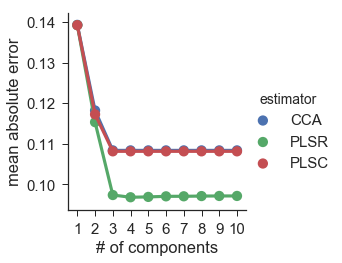

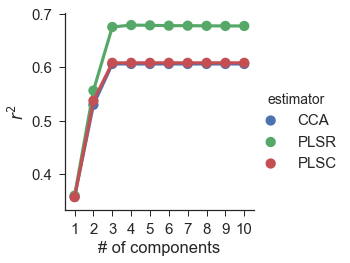

In [11]:
sns.set(font_scale=1.5)
sns.set_style('ticks')

sns.factorplot(x = 'nc', y='mae', hue = 'estimator', data=nc_chooser)
plt.ylabel('mean absolute error')
plt.xlabel('# of components')
#plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/figs/estimator_selection_cv_mae.pdf', 
#            bbox_inches='tight')
plt.show()

sns.factorplot(x = 'nc', y='r2', hue = 'estimator', data=nc_chooser)
plt.ylabel('$r^{2}$')
plt.xlabel('# of components')
#plt.savefig('figs/estimator_selection_cv_mae.pdf', bbox_inches='tight')
plt.show()

In [12]:
pls_mod = PLSRegression(n_components=3)
pls_mod.fit(tr,tr_y)

PLSRegression(copy=True, max_iter=500, n_components=3, scale=True, tol=1e-06)

finished iteration 0
finished iteration 100
finished iteration 200
finished iteration 300
finished iteration 400
finished iteration 500
finished iteration 600
finished iteration 700
finished iteration 800
finished iteration 900


//anaconda/envs/py3/lib/python3.5/site-packages/seaborn/categorical.py:1508: FutureWarning:

remove_na is deprecated and is a private function. Do not use.

//anaconda/envs/py3/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



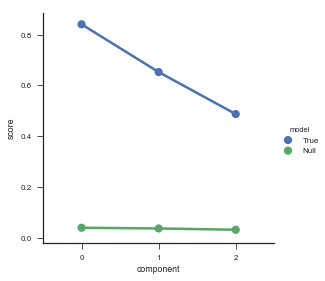

component 0: p = 0.001  ***
component 1: p = 0.001  ***
component 2: p = 0.001  ***


In [13]:
results, comp_sig = XD.evaluate_components(pls_mod, tr, tr_y, n_iterations=1000)

//anaconda/envs/py3/lib/python3.5/site-packages/seaborn/categorical.py:1508: FutureWarning:

remove_na is deprecated and is a private function. Do not use.

//anaconda/envs/py3/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



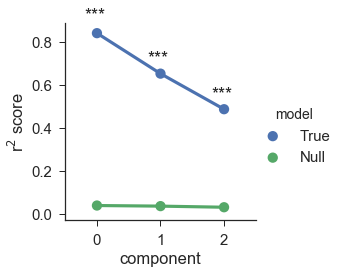

In [14]:
sns.set(font_scale=1.5)
sns.set_style('ticks')
sns.factorplot(x='component', y='score', hue='model', data=results)
plt.text(-0.20,0.9,'***')
plt.text(0.80,0.7,'***')
plt.text(1.80,0.53,'***')
plt.ylabel('r$^2$ score')
#plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/figs/sig_components.pdf',
#             bbox_inches='tight')

# Evaluate model

In [15]:
pls_mod = PLSRegression(n_components=3)
pls_mod.fit(tr,tr_y)

PLSRegression(copy=True, max_iter=500, n_components=3, scale=True, tol=1e-06)

//anaconda/envs/py3/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



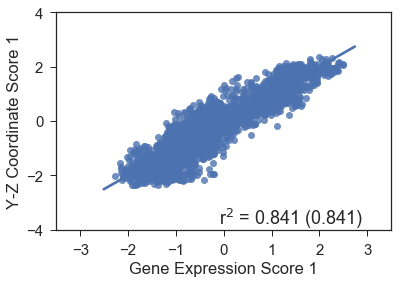

r2 = 0.8405143353412046, percent of total = 0.8405143353412046


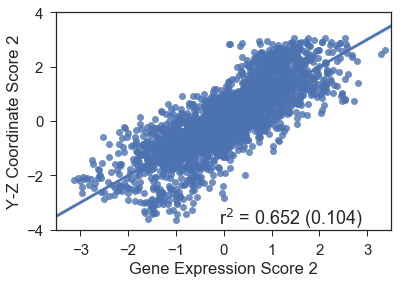

r2 = 0.6522670395795503, percent of total = 0.10402724234236942


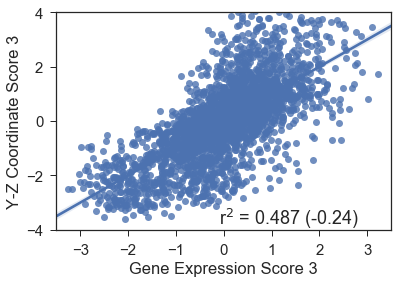

r2 = 0.48681366009909716, percent of total = -0.23989270475383814


In [16]:
# plot component scores
total = 1
leftover = 1
for i in range(pls_mod.n_components):
    r2 = stats.pearsonr(pls_mod.x_scores_[:,i], pls_mod.y_scores_[:,i])[0]**2
    explained = leftover * r2
    plt.close()
    sns.regplot(pls_mod.x_scores_[:,i], pls_mod.y_scores_[:,i])
    plt.xlim(-3.5,3.5)
    plt.ylim(-4,4)
    plt.xlabel('Gene Expression Score %i'%(i+1))
    plt.ylabel('Y-Z Coordinate Score %i'%(i+1))
    plt.text(-0.1,-3.8,'r$^2$ = %s (%s)'%(round(r2,3),round(explained,3)))
    #plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/principal_correlation_%s.pdf'%i,
    #           bbox_inches='tight')
    plt.show()
    print('r2 = %s, percent of total = %s'%(r2, explained))
    leftover = leftover - r2

//anaconda/envs/py3/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



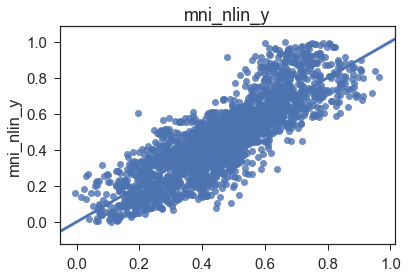

(0.840462141048248, 0.0)
0.08172070796008161


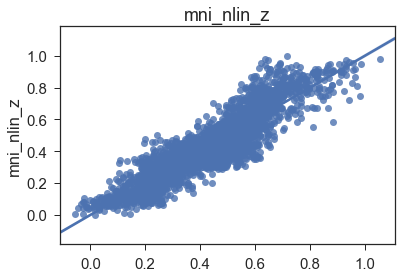

(0.8978798209151829, 0.0)
0.0703376615370209


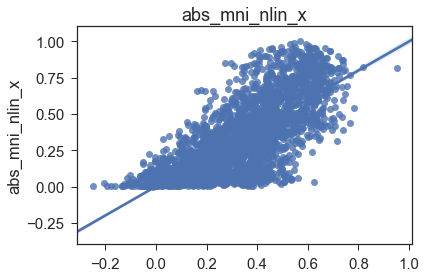

(0.7511186704798419, 0.0)
0.1318972204735161


In [19]:
# plot model fit
pred = pls_mod.predict(tr)
for i in range(tr_y.shape[-1]):
    plt.close()
    sns.regplot(pred[:,i], tr_y[tr_y.columns[i]])
    plt.title(tr_y.columns[i])
    plt.show()
    print(stats.pearsonr(pred[:,i], tr_y[tr_y.columns[i]]))
    print(mean_absolute_error(pred[:,i], tr_y[tr_y.columns[i]]))

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


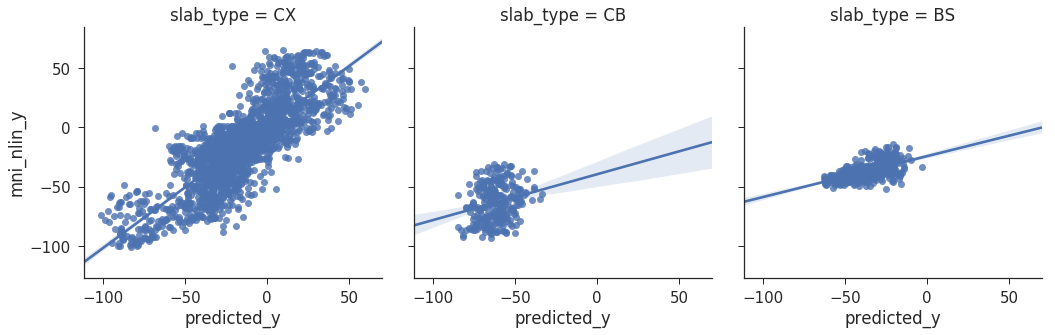

CX r2 =0.6631201936801722
CX mae =14.820794781871607
CB r2 =0.053367097919517784
CB mae =13.701445889266418
BS r2 =0.31898400680209543
BS mae =7.75813961436331


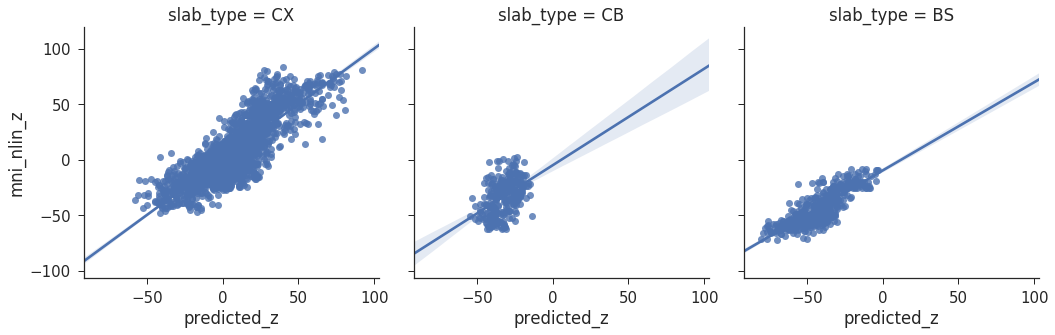

CX r2 =0.6984859832585868
CX mae =11.579876135138317
CB r2 =0.20004834332614896
CB mae =11.746166818206653
BS r2 =0.6800206147907996
BS mae =7.647003857921274


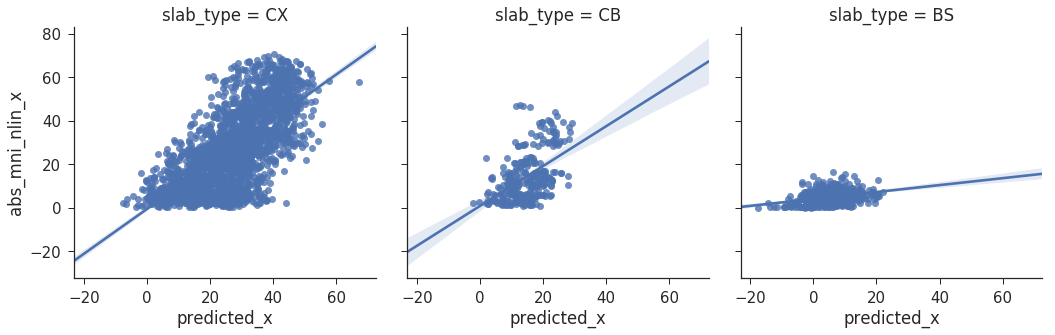

CX r2 =0.47037607892157857
CX mae =10.464256385174735
CB r2 =0.24637036138959548
CB mae =7.983081670374424
BS r2 =0.09864759649151211
BS mae =4.7979069107417285


In [22]:
# plot fit by slab type
preds_df = pandas.concat([pandas.DataFrame(pred, index=tr_y.index), tr_y],axis=1)
preds_df.columns = ['predicted_y', 'predicted_z','predicted_x'] + tr_y.columns.tolist()
preds_df.loc[:,'slab_type'] = gdf.loc[tr.index,'slab_type']
n_components = tr_y.shape[-1]
for i in range(n_components):
    plt.close()
    sns.lmplot(x=preds_df.columns[i], y = preds_df.columns[i+n_components], 
               col = 'slab_type', data = preds_df)
    #plt.title(preds_df.columns[i+n_components])
    plt.show()
    for slab in preds_df.slab_type.unique():
        if not pandas.notnull(slab):
            continue
        r2 = stats.pearsonr(preds_df[preds_df.slab_type==slab][preds_df.columns[i]],
                           preds_df[preds_df.slab_type==slab][preds_df.columns[i+n_components]]
                           )[0]**2
        mae = mean_absolute_error(preds_df[preds_df.slab_type==slab
                                          ][preds_df.columns[i]],
                                  preds_df[preds_df.slab_type==slab
                                          ][preds_df.columns[i+n_components]])
        print('%s r2 =%s'%(slab,r2))
        print('%s mae =%s'%(slab,mae))

# Test model

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


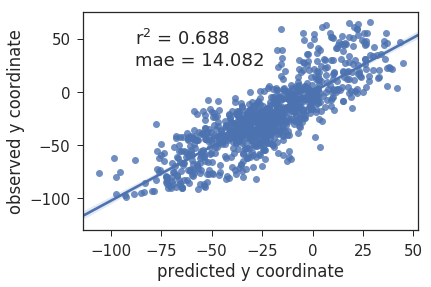

(0.8291858614014679, 1.22813072758626e-235)
14.08233631282719


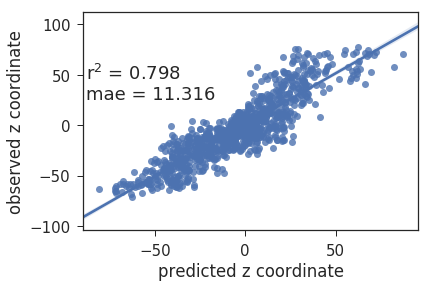

(0.8932820659855235, 4e-323)
11.31600842178105


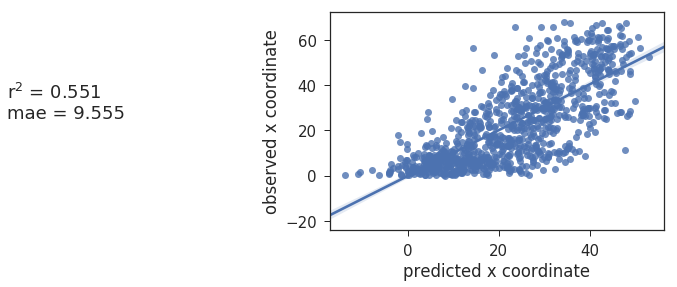

(0.7423632264750617, 6.913439963364357e-163)
9.554984761635462


In [23]:
# plot model fit
dims = ['y','z','x']
te_pred = pls_mod.predict(te)
for i in range(te_y.shape[-1]):
    r2 = stats.pearsonr(te_pred[:,i], te_y[te_y.columns[i]])[0]**2
    mae = mean_absolute_error(te_pred[:,i], te_y[te_y.columns[i]])
    plt.close()
    sns.regplot(te_pred[:,i], te_y[te_y.columns[i]])
    plt.xlabel('predicted %s coordinate'%dims[i])
    plt.ylabel('observed %s coordinate'%dims[i])
    plt.text(-88,25,'r$^2$ = %s\nmae = %s'%(round(r2,3),round(mae,3)))
    #plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/figs/predicted_%s.pdf'%dims[i],
    #           bbox_inches='tight')
    plt.show()
    print(stats.pearsonr(te_pred[:,i], te_y[te_y.columns[i]]))
    print(mean_absolute_error(te_pred[:,i], te_y[te_y.columns[i]]))

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


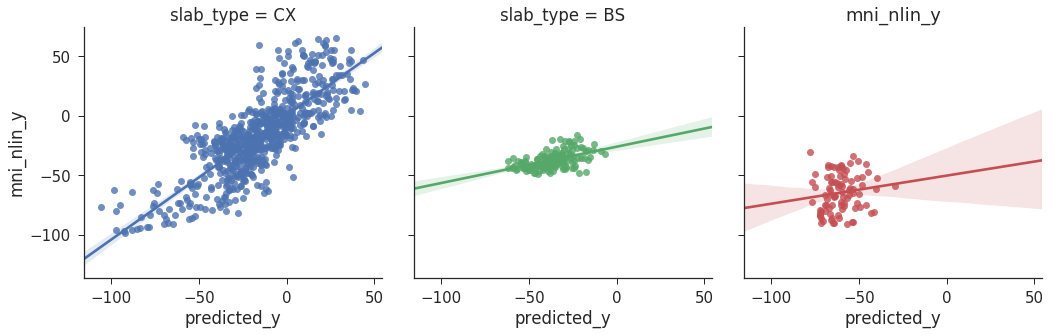

CX r2 =0.640749053609405
CX mae =15.353066235774431
BS r2 =0.25195139645888476
BS mae =7.740055852110806
CB r2 =0.01937542285577037
CB mae =14.385643996376107


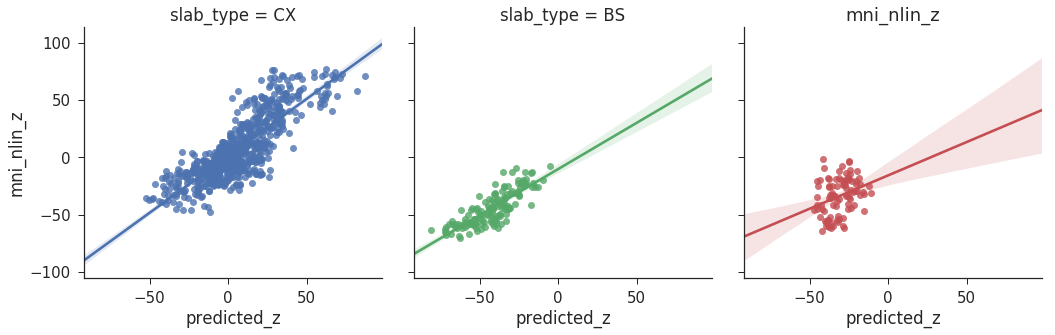

CX r2 =0.686164102860926
CX mae =11.859577216454845
BS r2 =0.6608810080760966
BS mae =7.556437050262962
CB r2 =0.09601207331537565
CB mae =13.090394138405442


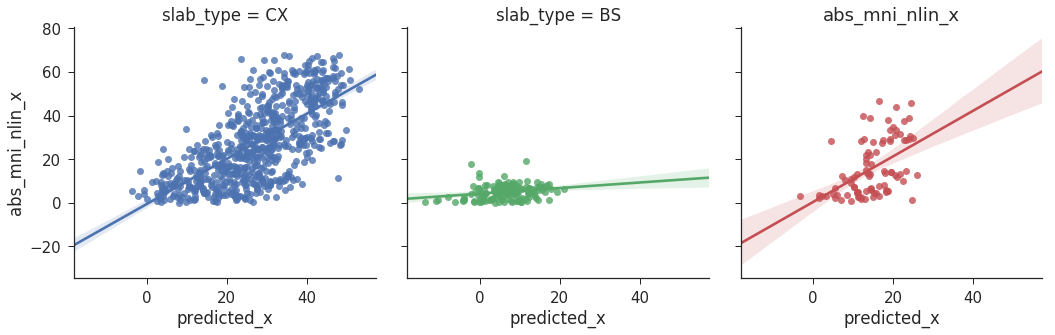

CX r2 =0.4612623873585864
CX mae =10.586213471017185
BS r2 =0.05496544872512819
BS mae =5.037337131393975
CB r2 =0.2603596122025401
CB mae =8.81227425869459


In [24]:
# plot fit by slab type
preds_df = pandas.concat([pandas.DataFrame(te_pred, index=te_y.index), te_y],axis=1)
preds_df.columns = ['predicted_y', 'predicted_z', 'predicted_x'] + te_y.columns.tolist()
preds_df.loc[:,'slab_type'] = gdf.loc[te.index,'slab_type']
n_components = te_y.shape[-1]
for i in range(n_components):
    plt.close()
    sns.lmplot(x=preds_df.columns[i], y = preds_df.columns[i+n_components], hue = 'slab_type', 
               col = 'slab_type', data = preds_df)
    #plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/figs/%s_by_slabtype.pdf'%preds_df.columns[i],
    #           bbox_inches = 'tight')
    plt.title(preds_df.columns[i+n_components])
    plt.show()
    for slab in preds_df.slab_type.unique():
        r2 = stats.pearsonr(preds_df[preds_df.slab_type==slab][preds_df.columns[i]],
                           preds_df[preds_df.slab_type==slab][preds_df.columns[i+n_components]]
                           )[0]**2
        mae = mean_absolute_error(preds_df[preds_df.slab_type==slab
                                          ][preds_df.columns[i]],
                                  preds_df[preds_df.slab_type==slab
                                          ][preds_df.columns[i+n_components]])
        print('%s r2 =%s'%(slab,r2))
        print('%s mae =%s'%(slab,mae))

In [20]:
pls_mod = PLSRegression(n_components=3)
full_y = gdf[['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]
pls_mod.fit(pca_tfm, full_y)

PLSRegression(copy=True, max_iter=500, n_components=3, scale=True, tol=1e-06)

finished iteration 0
finished iteration 100
finished iteration 200
finished iteration 300
finished iteration 400
finished iteration 500
finished iteration 600
finished iteration 700
finished iteration 800
finished iteration 900


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):
/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


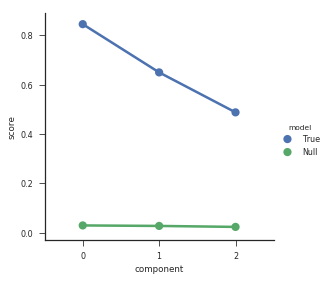

component 0: p = 0.001  ***
component 1: p = 0.001  ***
component 2: p = 0.001  ***


In [28]:
# significant components?
results, comp_sig = XD.evaluate_components(pls_mod, pca_tfm, full_y, n_iterations=1000)

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):
/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


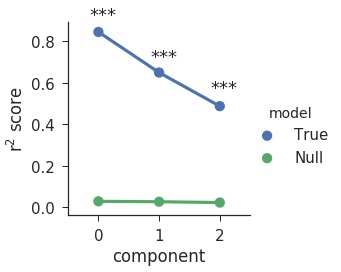

In [31]:
sns.set(font_scale=1.5)
sns.set_style('ticks')
sns.factorplot(x='component', y='score', hue='model', data=results)
plt.text(-0.15,0.9,'***')
plt.text(0.85,0.7,'***')
plt.text(1.85,0.55,'***')
plt.ylabel('r$^2$ score')
#plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/figs/FULLMOD_sig_components.pdf',
#            bbox_inches='tight')
plt.show()

# Build and evaluate model on all data

In [21]:
pls_mod.fit(pca_tfm, full_y)

PLSRegression(copy=True, max_iter=500, n_components=3, scale=True, tol=1e-06)

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


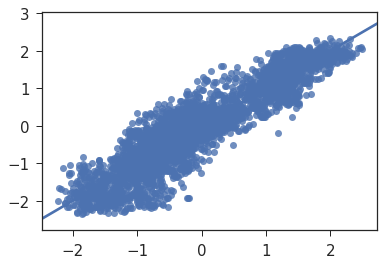

r2 = 0.8446798378447, percent of total = 0.8446798378447


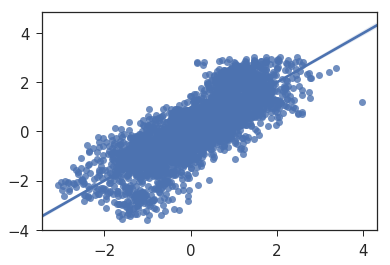

r2 = 0.6493009890148428, percent of total = 0.10084953490138203


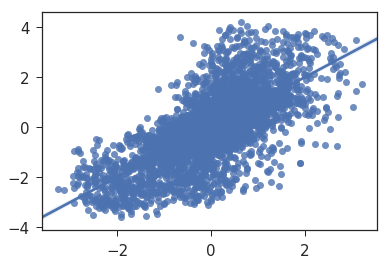

r2 = 0.487420565286997, percent of total = -0.24077641386881654


In [33]:
pls_mod.fit(pca_tfm, gdf[['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']])
# plot component scores
total = 1
leftover = 1
for i in range(pls_mod.n_components):
    plt.close()
    sns.regplot(pls_mod.x_scores_[:,i], pls_mod.y_scores_[:,i])
    plt.show()
    r2 = stats.pearsonr(pls_mod.x_scores_[:,i], pls_mod.y_scores_[:,i])[0]**2
    explained = leftover * r2
    print('r2 = %s, percent of total = %s'%(r2, explained))
    leftover = leftover - r2

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


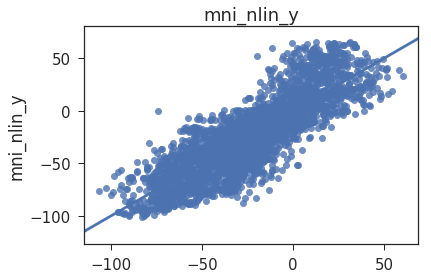

(0.8400512595902042, 0.0)
13.654236880130231


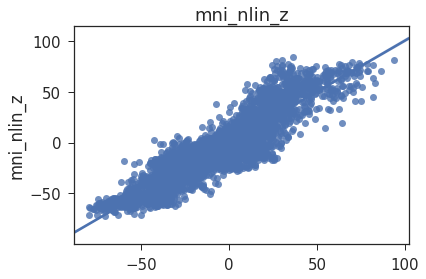

(0.8995530952285967, 0.0)
10.892298113898361


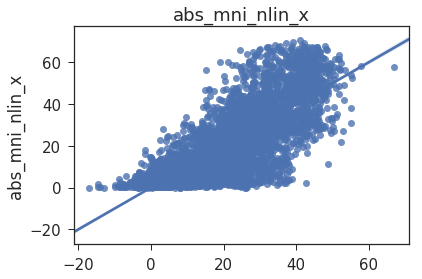

(0.7517896954737591, 0.0)
9.292536551534182


In [34]:
# plot model fit
pred = pls_mod.predict(pca_tfm)
for i in range(full_y.shape[-1]):
    plt.close()
    sns.regplot(pred[:,i], full_y[full_y.columns[i]])
    plt.title(full_y.columns[i])
    plt.show()
    print(stats.pearsonr(pred[:,i], full_y[full_y.columns[i]]))
    print(mean_absolute_error(pred[:,i], full_y[full_y.columns[i]]))

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


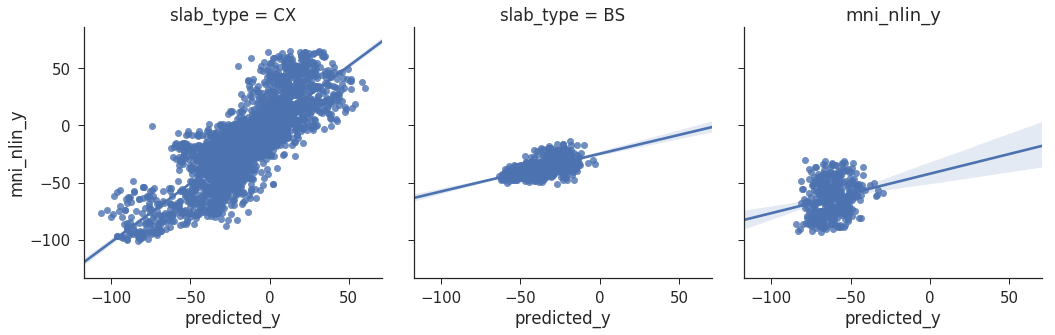

CX r2 =0.6635352787196934
CX mae =45.78637606922774
BS r2 =0.2942868455752306
BS mae =41.9182483792791
CB r2 =0.04620300372151648
CB mae =77.10609045880598


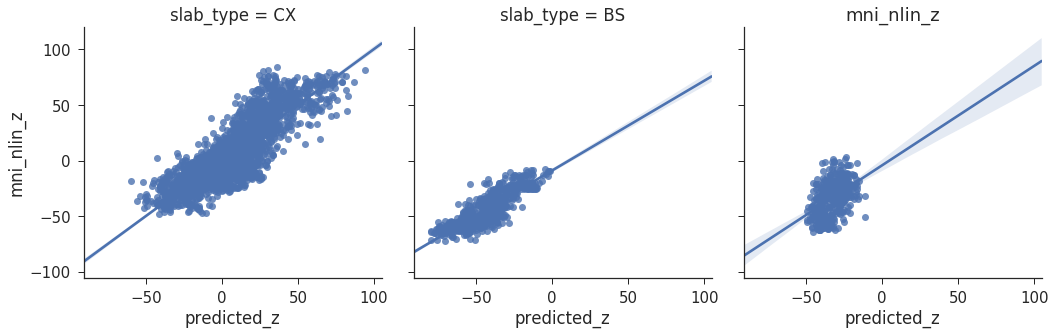

CX r2 =0.6996902868538534
CX mae =36.395468963522674
BS r2 =0.7056946351280543
BS mae =12.15694783822998
CB r2 =0.20672980989051196
CB mae =31.444069326603614


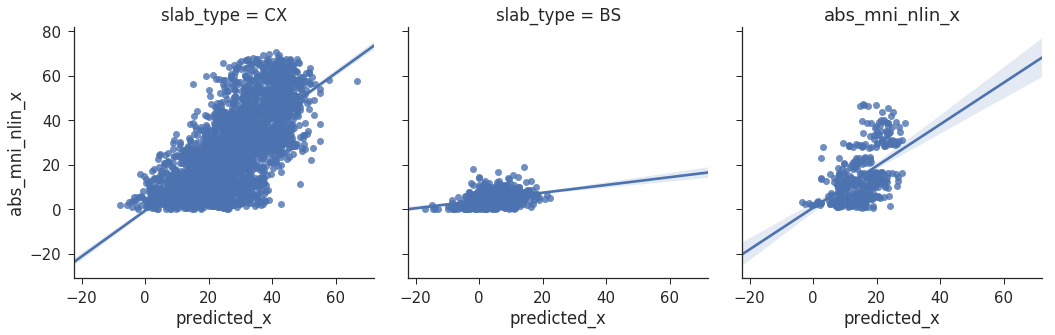

CX r2 =0.47057898312290714
CX mae =30.21270231102337
BS r2 =0.10380860846062731
BS mae =48.412755247738936
CB r2 =0.2543215774638597
CB mae =48.28909479148206


In [35]:
# plot fit by slab type
preds_df = pandas.concat([pandas.DataFrame(pred, index=full_y.index), full_y],axis=1)
preds_df.columns = ['predicted_y', 'predicted_z', 'predicted_x'] + full_y.columns.tolist()
preds_df.loc[:,'slab_type'] = gdf.loc[pca_tfm.index,'slab_type']
n_components = full_y.shape[-1]
for i in range(n_components):
    plt.close()
    sns.lmplot(x=preds_df.columns[i], y = preds_df.columns[i+n_components], 
               col = 'slab_type', data = preds_df)
    plt.title(preds_df.columns[i+n_components])
    plt.show()
    for slab in preds_df.slab_type.unique():
        r2 = stats.pearsonr(preds_df[preds_df.slab_type==slab][preds_df.columns[i]],
                           preds_df[preds_df.slab_type==slab][preds_df.columns[i+n_components]]
                           )[0]**2
        mae = mean_absolute_error(preds_df[preds_df.slab_type==slab
                                          ][preds_df.columns[i]],
                                  preds_df[preds_df.slab_type==slab
                                          ][preds_df.columns[i+2]])
        print('%s r2 =%s'%(slab,r2))
        print('%s mae =%s'%(slab,mae))

# Visualize predictions

In [36]:
preds_df.loc[:,'structure'] = gdf.structure_acronym.values

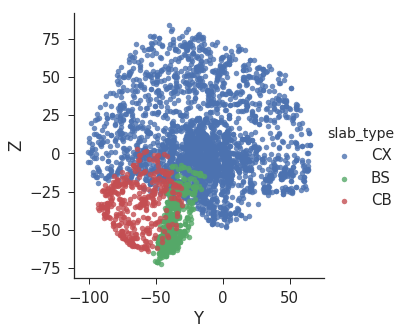

In [37]:
sns.lmplot('mni_nlin_y', 'mni_nlin_z', hue = 'slab_type', data=gdf, fit_reg=False, 
           scatter_kws={"s": 30})
plt.xlabel('Y')
plt.ylabel('Z')
#plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/figs/brain_plot.pdf',
#           bbox_inches='tight')

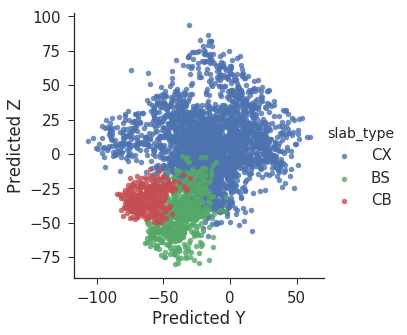

In [38]:
sns.lmplot('predicted_y', 'predicted_z', hue = 'slab_type', data=preds_df, 
           fit_reg=False, scatter_kws={"s": 30})
plt.xlabel('Predicted Y')
plt.ylabel('Predicted Z')
#plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/figs/brain_plot_predicted.pdf',
#           bbox_inches='tight')

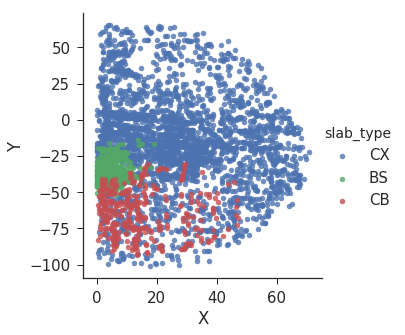

In [39]:
sns.lmplot('abs_mni_nlin_x', 'mni_nlin_y', hue = 'slab_type', data=gdf, fit_reg=False, 
           scatter_kws={"s": 30})
plt.xlabel('X')
plt.ylabel('Y')
#plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/figs/brain_plot.pdf',
#           bbox_inches='tight')

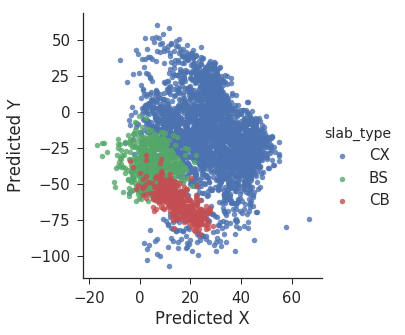

In [40]:
sns.lmplot('predicted_x', 'predicted_y', hue = 'slab_type', data=preds_df, 
           fit_reg=False, scatter_kws={"s": 30})
plt.xlabel('Predicted X')
plt.ylabel('Predicted Y')
#plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/figs/brain_plot_predicted.pdf',
#           bbox_inches='tight')

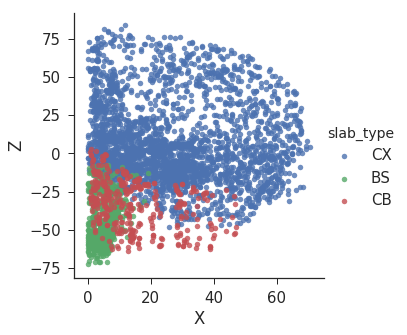

In [41]:
sns.lmplot('abs_mni_nlin_x', 'mni_nlin_z', hue = 'slab_type', data=gdf, fit_reg=False, 
           scatter_kws={"s": 30})
plt.xlabel('X')
plt.ylabel('Z')
#plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/figs/brain_plot.pdf',
#           bbox_inches='tight')

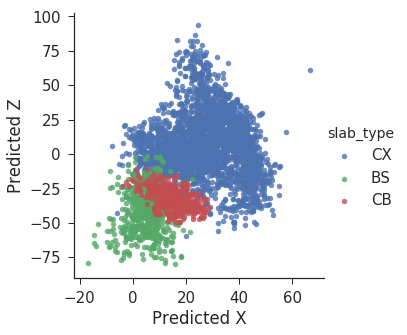

In [42]:
sns.lmplot('predicted_x', 'predicted_z', hue = 'slab_type', data=preds_df, 
           fit_reg=False, scatter_kws={"s": 30})
plt.xlabel('Predicted X')
plt.ylabel('Predicted Z')
#plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/figs/brain_plot_predicted.pdf',
#           bbox_inches='tight')

In [97]:
labs = [0 if gdf.loc[x,'slab_type'] == 'CX' else 1 if gdf.loc[x,'slab_type'] == 'BS' else 2 for x in gdf.index]
embedding = gdf[['abs_mni_nlin_x','mni_nlin_y','mni_nlin_z']].values

lmap = dict(zip(np.unique(labs),gdf.slab_type.unique()))
traces = list()
for lab in np.unique(labs):
    l_index = [x for x in range(len(labs)) if labs[x] == lab]
    l_embed = embedding[l_index]
#     color_str = str(int('0x' + color_dict[lab][1:3].upper(),16)) + ',' + \
#                    str(int('0x' + color_dict[lab][3:5].upper(),16)) + ',' + \
#                    str(int('0x' + color_dict[lab][5:7].upper(),16))
    #color_str = plt.cm.tab10.colors[lab]
    color_str = 'rgba %s'%str(tuple([x - 0.0000001 for x in plt.cm.tab10(lab) if x > 0]))
    temp_trace = plotly.graph_objs.Scatter3d(x=l_embed[:,0],
                                            y = l_embed[:,1],
                                            z = l_embed[:,2],
                                            name = lmap[lab],
                                            mode = 'markers',
                                            marker = dict(size=3,
                                                          color=color_str
                                                         )
                                            )
    traces.append(temp_trace)

layout = plotly.graph_objs.Layout(margin = dict(l=0,r=0,b=0,t=0))

fig = plotly.graph_objs.Figure(data=traces, layout=layout)
plotly.offline.plot(fig, filename='brain.html')
    

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/subprocess.py:761: ResourceWarning:

subprocess 14668 is still running



'file:///home/users/jvogel/git/hack_projects/brain.html'

In [98]:
labs = [0 if gdf.loc[x,'slab_type'] == 'CX' else 1 if gdf.loc[x,'slab_type'] == 'BS' else 2 for x in gdf.index]
embedding = preds_df[['predicted_x','predicted_y','predicted_z']].values

lmap = dict(zip(np.unique(labs),gdf.slab_type.unique()))
traces = list()
for lab in np.unique(labs):
    l_index = [x for x in range(len(labs)) if labs[x] == lab]
    l_embed = embedding[l_index]
#     color_str = str(int('0x' + color_dict[lab][1:3].upper(),16)) + ',' + \
#                    str(int('0x' + color_dict[lab][3:5].upper(),16)) + ',' + \
#                    str(int('0x' + color_dict[lab][5:7].upper(),16))
    #color_str = plt.cm.tab10.colors[lab]
    color_str = 'rgba %s'%str(tuple([x - 0.0000001 for x in plt.cm.tab10(lab) if x > 0]))
    temp_trace = plotly.graph_objs.Scatter3d(x=l_embed[:,0],
                                            y = l_embed[:,1],
                                            z = l_embed[:,2],
                                            name = lmap[lab],
                                            mode = 'markers',
                                            marker = dict(size=3,
                                                          color=color_str
                                                         )
                                            )
    traces.append(temp_trace)

layout = plotly.graph_objs.Layout(margin = dict(l=0,r=0,b=0,t=0))

fig = plotly.graph_objs.Figure(data=traces, layout=layout)
plotly.offline.plot(fig, filename='predicted_brain.html')
    

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/subprocess.py:761: ResourceWarning:

subprocess 14728 is still running



'file:///home/users/jvogel/git/hack_projects/predicted_brain.html'

# Examine components

In [77]:
pls_mod = PLSRegression(n_components=3)
pls_mod.fit(pca_tfm, full_y)
bsrx, bsry, allx_bs, ally_bs = XD.bootstrap_features(PLSRegression(n_components=3), 
                                                  pls_mod, 
                                                  pca_tfm, 
                                                  gdf[['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']], 
                                                  n_iterations=1000)

finished iteration 0
finished iteration 100
finished iteration 200
finished iteration 300
finished iteration 400
finished iteration 500
finished iteration 600
finished iteration 700
finished iteration 800
finished iteration 900


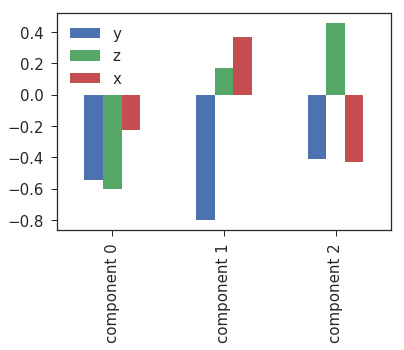

In [119]:
pandas.DataFrame(pls_mod.y_weights_, 
                 index=['component %s'%x for x in range(3)],
                 columns=['y','z','x']).plot.bar()

In [46]:
plotr = pandas.concat([pandas.Series(allx_bs[0].values.flatten()),
                       #pandas.Series(list(range(100))*500)],
                       pandas.Series(list(range(100))*1000)],
                      axis=1)
plotr.columns = ['Loading','Component']

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):
/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


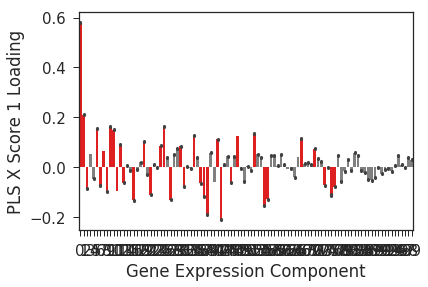

In [47]:
sns.set(font_scale=1.5)
sns.set_style('ticks')
colors = ['Red' if x else 'Grey' for x in multipletests(bsrx['p'].loc[0], method='fdr_bh')[0]]
sns.barplot(x='Component', y='Loading', data=plotr, palette=colors)
plt.xlabel('Gene Expression Component')
plt.ylabel('PLS X Score 1 Loading')
#plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/figs/C1_x_loadings.pdf',
#           bbox_inches='tight')
#g.set_xticklabels([None for x in range(100)])
#plt.xticks(['' for x in range(100)])

In [48]:
sigs = multipletests(bsrx['p'].loc[0], method='fdr_bh')[0]
new_loading = [pls_mod.x_loadings_[x,0] if sigs[x] else 0 for x in range(pca_tfm.shape[-1])]

In [49]:
newc1 = np.dot(pcamod.components_.T, new_loading)
newc1 = pandas.concat([pandas.Series(newc1), probes[['gene_symbol','gene_name']]], axis=1)

In [50]:
newc1.sort_values(0,ascending=False)

0    gene_symbol  \
612    0.049037            DAO   
53500  0.045484   A_24_P815062   
2313   0.044948          HOXB5   
2306   0.043233          HOXB2   
26396  0.042538           PAX2   
2307   0.041478          HOXB3   
2290   0.039242          HOXA4   
38830  0.036459           IRX2   
2288   0.035116          HOXA2   
611    0.035037            DAO   
2297   0.034890          HOXA7   
48925  0.034881   A_23_P344673   
29284  0.034590          HOXA3   
4879   0.034501           PRPH   
2295   0.034384          HOXA6   
2342   0.032132          HOXD3   
52908  0.031673   A_24_P101282   
2309   0.031104          HOXB3   
10340  0.031079          STON1   
3404   0.030869            MET   
10341  0.029268          STON1   
6754   0.027750         TFAP2B   
45160  0.027644           IRX2   
2293   0.027166          HOXA5   
2315   0.026922          HOXB6   
5083   0.026557         POU4F1   
22271  0.026327        C5orf38   
9465   0.026323           IRX5   
17803  0.026306         SLC5A7   
38062  0.025951  RP11-834C11.4   
...         ...            ...   
8446  -0.032353           LHX2   
28782 -0.032354         OR14I1   
41426 -0.032514          CTXN3   
58161 -0.032528   A_24_P564761   
41367 -0.032916          CTXN3   
6453  -0.033430          NR2E1   
33199 -0.033601          RXFP1   
41725 -0.033832           NRGN   
52121 -0.034009   A_23_P124534   
14589 -0.034019          FEZF2   
37101 -0.034153         FRMPD2   
22848 -0.034226        GALNTL5   
8691  -0.035575            GDA   
7825  -0.036011          HSPB3   
42966 -0.036630       KIAA0748   
52    -0.036789            CCK   
51    -0.036963            CCK   
29452 -0.037490         THEMIS   
47141 -0.038035          TNNT2   
37982 -0.038363          CTXN3   
37994 -0.038493           NRGN   
38314 -0.038609       KIAA0748   
12304 -0.038964          MOXD1   
33641 -0.040530           DLX1   
30220 -0.041431          TNNT2   
8692  -0.041499            GDA   
56559 -0.042724    A_32_P85405   
30221 -0.044418          TNNT2   
21889 -0.045158        TMEM155   
46969 -0.049558         FOXG1B   

                                               gene_name  
612                                 D-amino-acid oxidase  
53500            AGILENT probe A_24_P815062 (non-RefSeq)  
2313                                         homeobox B5  
2306                                         homeobox B2  
26396                                       paired box 2  
2307                                         homeobox B3  
2290                                         homeobox A4  
38830                                iroquois homeobox 2  
2288                                         homeobox A2  
611                                 D-amino-acid oxidase  
2297                                         homeobox A7  
48925            AGILENT probe A_23_P344673 (non-RefSeq)  
29284                                        homeobox A3  
4879                                          peripherin  
2295                                         homeobox A6  
2342                                         homeobox D3  
52908            AGILENT probe A_24_P101282 (non-RefSeq)  
2309                                         homeobox B3  
10340                                           stonin 1  
3404   met proto-oncogene (hepatocyte growth factor r...  
10341                                           stonin 1  
6754   transcription factor AP-2 beta (activating enh...  
45160                                iroquois homeobox 2  
2293                                         homeobox A5  
2315                                         homeobox B6  
5083                              POU class 4 homeobox 1  
22271                 chromosome 5 open reading frame 38  
9465                                 iroquois homeobox 5  
17803  solute carrier family 5 (choline transporter),...  
38062                          uncharacterized LOC400043  
...                                                  ...  
8446             

In [53]:
c1_xp = hap.get_gene_vector(pandas.DataFrame(bigdf.T), newc1[0])

In [299]:
input_coords = []
for i,row in gdf.iterrows():
    input_coords.append(hap.convert_coords([round(int(row['mni_nlin_x'])), 
                                        round(int(row['mni_nlin_y'])), 
                                        round(int(row['mni_nlin_z']))], 'xyz'))
nm = 'NEUR608_IMG_c1'
mni_pth = '/home/users/jvogel/Science/templates/templates/MNI152_T1_1mm_brain.nii'
wdir = '/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ADDX/'
gcx_img = hap.make_expression_image(c1_xp, input_coords, mni_pth, wdir, nm, 5, return_img=True)

In [58]:
plotting.view_img(gcx_img)

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


In [59]:
plotr = pandas.concat([pandas.Series(allx_bs[1].values.flatten()),
                       pandas.Series(list(range(100))*1000)],
                      axis=1)
plotr.columns = ['Loading','Component']

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):
/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


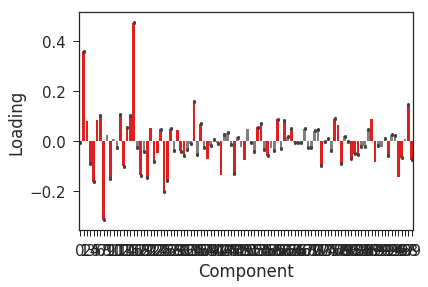

In [60]:
colors = ['Red' if x < 0.05 else 'Grey' for x in bsrx['p'].loc[1]]
sns.barplot(x='Component', y='Loading', data=plotr, palette=colors)

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):
/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


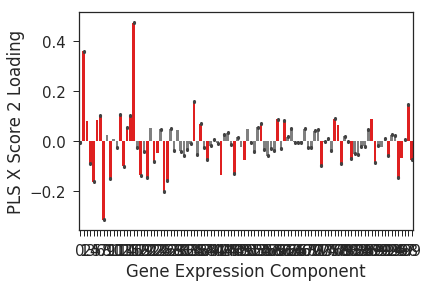

In [61]:
colors = ['Red' if x else 'Grey' for x in multipletests(bsrx['p'].loc[1], method='fdr_bh')[0]]
sns.barplot(x='Component', y='Loading', data=plotr, palette=colors)
plt.xlabel('Gene Expression Component')
plt.ylabel('PLS X Score 2 Loading')
#plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/figs/C2_x_loadings.pdf',
#           bbox_inches='tight')

In [62]:
sigs = multipletests(bsrx['p'].loc[1], method='fdr_bh')[0]
new_loading = [pls_mod.x_loadings_[x,1] if sigs[x] else 0 for x in range(pca_tfm.shape[-1])]
newc2 = np.dot(pcamod.components_.T, new_loading)
newc2 = pandas.concat([pandas.Series(newc2), probes[['gene_symbol','gene_name']]], axis=1)

In [63]:
newc2.sort_values(0,ascending=False)

0   gene_symbol  \
6582   0.049877           TTR   
3404   0.035842           MET   
6581   0.032821           TTR   
3405   0.031086           MET   
5009   0.029757         PVALB   
5008   0.029737         PVALB   
16210  0.028918          LHX9   
13405  0.027659          SOST   
3403   0.025559           MET   
2941   0.025396          LAG3   
26331  0.024294         SCN1B   
22599  0.023713         XIRP1   
10442  0.023355          ESM1   
40710  0.023200         ITGB2   
31111  0.023055         PTGS1   
31892  0.022377        CADPS2   
157    0.022310          CD70   
12553  0.022098       BHLHE22   
15951  0.021697         TDRD1   
478    0.021611        COX7A1   
26330  0.021561         SCN1B   
11988  0.021347          SMPX   
15863  0.020642       SLC17A6   
54829  0.020284   A_32_P78705   
2940   0.020052          LAG3   
23009  0.019997         USP54   
15851  0.019877       SLC17A6   
6475   0.019709           TNF   
18979  0.019411        AGPAT9   
15864  0.019315       SLC17A6   
...         ...           ...   
49797 -0.023072  A_32_P146597   
22614 -0.023268       FAM163A   
37982 -0.023399         CTXN3   
6786  -0.023468         TGFBI   
56266 -0.023587  A_24_P586072   
39129 -0.023825     LINC00238   
12942 -0.024004           GAL   
28305 -0.024192        PTGER3   
102   -0.024257           CD6   
40188 -0.024877        AMIGO2   
48647 -0.024918  A_24_P525749   
32711 -0.025486        PTGER3   
8716  -0.025492          MTL5   
8402  -0.025595        BAIAP3   
32813 -0.026822          RBP4   
20805 -0.027044        TWIST2   
22838 -0.027304        PRSS23   
54487 -0.029326  A_32_P115840   
5979  -0.029556           SLN   
49718 -0.029987  A_23_P104484   
6529  -0.030724           TRH   
52653 -0.030876  A_32_P146485   
5978  -0.031928           SLN   
36851 -0.032496        AMIGO2   
24515 -0.032918         SYT10   
18215 -0.033021          GSG1   
28306 -0.033343        PTGER3   
38288 -0.033541         FREM3   
24514 -0.036851         SYT10   
57805 -0.044551   A_32_P64286   

                                               gene_name  
6582                                       transthyretin  
3404   met proto-oncogene (hepatocyte growth factor r...  
6581                                       transthyretin  
3405   met proto-oncogene (hepatocyte growth factor r...  
5009                                         parvalbumin  
5008                                         parvalbumin  
16210                                     LIM homeobox 9  
13405                                         sclerostin  
3403   met proto-oncogene (hepatocyte growth factor r...  
2941                        lymphocyte-activation gene 3  
26331  sodium channel, voltage-gated, type I, beta su...  
22599              xin actin-binding repeat containing 1  
10442               endothelial cell-specific molecule 1  
40710  integrin, beta 2 (complement component 3 recep...  
31111  prostaglandin-endoperoxide synthase 1 (prostag...  
31892               Ca++-dependent secretion activator 2  
157                                        CD70 molecule  
12553          basic helix-loop-helix family, member e22  
15951                          tudor domain containing 1  
478    cytochrome c oxidase subunit VIIa polypeptide ...  
26330  sodium channel, voltage-gated, type I, beta su...  
11988                     small muscle protein, X-linked  
15863  solute carrier family 17 (sodium-dependent ino...  
54829             AGILENT probe A_32_P78705 (non-RefSeq)  
2940                        lymphocyte-activation gene 3  
23009                    ubiquitin specific peptidase 54  
15851  solute carrier family 17 (sodium-dependent ino...  
6475                               tumor necrosis factor  
18979     1-acylglycerol-3-phosphate O-acyltransferase 9  
15864  solute carrier family 17 (sodium-dependent ino...  
...                                                  ...  
49797            AGILENT probe A_32_P146597 (non-RefSeq)  
22614      family wi

In [66]:
c2_xp = hap.get_gene_vector(pandas.DataFrame(bigdf.T), newc2[0])

In [300]:
input_coords = []
for i,row in gdf.iterrows():
    input_coords.append(hap.convert_coords([round(int(row['mni_nlin_x'])), 
                                        round(int(row['mni_nlin_y'])), 
                                        round(int(row['mni_nlin_z']))], 'xyz'))
nm = 'NEUR608_IMG_c2'
mni_pth = '/home/users/jvogel/Science/templates/templates/MNI152_T1_1mm_brain.nii'
wdir = '/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ADDX/'
gcx_img = hap.make_expression_image(c2_xp, input_coords, mni_pth, wdir, nm, 5, return_img=True)

In [69]:
plotting.view_img(gcx_img)

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


In [76]:
bsrx['p']

0      1      2      3      4      5      6      7      8      9   \
0  0.001  0.001  0.002  0.045  0.062  0.001  0.005  0.006  0.003  0.001   
1  0.437  0.001  0.003  0.001  0.001  0.001  0.001  0.001  0.193  0.001   
2  0.437  0.001  0.003  0.001  0.001  0.001  0.001  0.001  0.193  0.001   

   ...       90     91     92     93     94     95     96     97     98     99  
0  ...    0.157   0.39  0.454  0.301  0.384  0.069  0.381  0.508  0.147  0.146  
1  ...    0.195  0.331  0.017  0.163  0.208  0.001  0.006  0.388  0.001  0.011  
2  ...    0.195  0.331  0.017  0.163  0.208  0.001  0.006  0.388  0.001  0.011  

[3 rows x 100 columns]

In [79]:
plotr = pandas.concat([pandas.Series(allx_bs[2].values.flatten()),
                       pandas.Series(list(range(100))*1000)],
                      axis=1)
plotr.columns = ['Loading','Component']

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):
/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


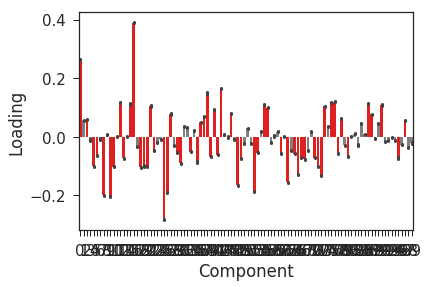

In [80]:
colors = ['Red' if x < 0.05 else 'Grey' for x in bsrx['p'].loc[2]]
sns.barplot(x='Component', y='Loading', data=plotr, palette=colors)

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):
/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


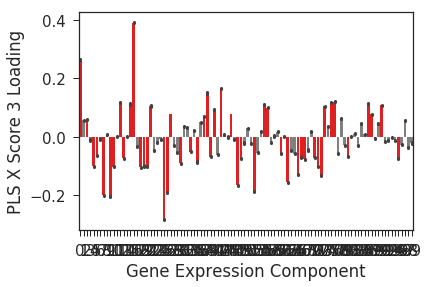

In [81]:
sns.set(font_scale=1.5)
sns.set_style('ticks')
colors = ['Red' if x else 'Grey' for x in multipletests(bsrx['p'].loc[2], method='fdr_bh')[0]]
sns.barplot(x='Component', y='Loading', data=plotr, palette=colors)
plt.xlabel('Gene Expression Component')
plt.ylabel('PLS X Score 3 Loading')
#plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/figs/C1_x_loadings.pdf',
#           bbox_inches='tight')
#g.set_xticklabels([None for x in range(100)])
#plt.xticks(['' for x in range(100)])

In [82]:
sigs = multipletests(bsrx['p'].loc[2], method='fdr_bh')[0]
new_loading = [pls_mod.x_loadings_[x,2] if sigs[x] else 0 for x in range(pca_tfm.shape[-1])]
newc3 = np.dot(pcamod.components_.T, new_loading)
newc3 = pandas.concat([pandas.Series(newc3), probes[['gene_symbol','gene_name']]], axis=1)

In [83]:
newc3.sort_values(0,ascending=False)

0   gene_symbol  \
6582   0.061636           TTR   
58161  0.044089  A_24_P564761   
37982  0.042332         CTXN3   
6581   0.038875           TTR   
41426  0.037331         CTXN3   
45721  0.036007        CSN1S1   
41367  0.035611         CTXN3   
53627  0.033695  A_23_P417646   
53626  0.032727  A_23_P417646   
4060   0.032271           NTS   
4062   0.032105           NTS   
12940  0.032032           GAL   
12941  0.031772           GAL   
12939  0.031681           GAL   
12938  0.031347           GAL   
4299   0.031296          PCP4   
4300   0.030911          PCP4   
12942  0.030896           GAL   
4301   0.030734          PCP4   
8963   0.029994       ONECUT2   
4057   0.029263           NTS   
4067   0.029241           NTS   
8962   0.029188       ONECUT2   
47838  0.029095  A_32_P227921   
4063   0.029087           NTS   
4059   0.028991           NTS   
4064   0.028608           NTS   
4058   0.027212           NTS   
30856  0.026875          SV2C   
30855  0.026741          SV2C   
...         ...           ...   
35514 -0.028234     POM121L8P   
4411  -0.028261          PDYN   
7073  -0.028523         TYRP1   
47295 -0.029389       TP53I11   
44787 -0.029760         ASCL2   
28427 -0.029880        AKAP14   
4410  -0.030178          PDYN   
4400  -0.030850          PDYN   
24931 -0.030860         KCTD4   
4407  -0.031015          PDYN   
24685 -0.031115         PYDC1   
4629  -0.031940          PNMT   
25182 -0.031967     LOC392145   
3403  -0.032354           MET   
28305 -0.032413        PTGER3   
25511 -0.032814       FAM19A1   
53734 -0.032989      C1orf187   
24932 -0.033395         KCTD4   
3858  -0.034163           MGP   
13152 -0.034203        DUSP13   
4375  -0.035190          NPPA   
32711 -0.035331        PTGER3   
23087 -0.035523          EXD1   
4628  -0.035850          PNMT   
3404  -0.037019           MET   
26396 -0.038915          PAX2   
46069 -0.040268          KLK8   
44020 -0.040551  LOC100129291   
3405  -0.043268           MET   
28306 -0.044095        PTGER3   

                                               gene_name  
6582                                       transthyretin  
58161            AGILENT probe A_24_P564761 (non-RefSeq)  
37982                                         cortexin 3  
6581                                       transthyretin  
41426                                         cortexin 3  
45721                                    casein alpha s1  
41367                                         cortexin 3  
53627            AGILENT probe A_23_P417646 (non-RefSeq)  
53626            AGILENT probe A_23_P417646 (non-RefSeq)  
4060                                         neurotensin  
4062                                         neurotensin  
12940                              galanin prepropeptide  
12941                              galanin prepropeptide  
12939                              galanin prepropeptide  
12938                              galanin prepropeptide  
4299                             Purkinje cell protein 4  
4300                             Purkinje cell protein 4  
12942                              galanin prepropeptide  
4301                             Purkinje cell protein 4  
8963                                  one cut homeobox 2  
4057                                         neurotensin  
4067                                         neurotensin  
8962                                  one cut homeobox 2  
47838            AGILENT probe A_32_P227921 (non-RefSeq)  
4063                                         neurotensin  
4059                                         neurotensin  
4064                                         neurotensin  
4058                                         neurotensin  
30856                   synaptic vesicle glycoprotein 2C  
30855                   synaptic vesicle glycoprotein 2C  
...                                                  ...  
35514  POM121 transmembrane nucleoporin-like 8 pseudo...  
4411                

In [84]:
c3_xp = hap.get_gene_vector(pandas.DataFrame(bigdf.T), newc3[0])

In [301]:
input_coords = []
for i,row in gdf.iterrows():
    input_coords.append(hap.convert_coords([round(int(row['mni_nlin_x'])), 
                                        round(int(row['mni_nlin_y'])), 
                                        round(int(row['mni_nlin_z']))], 'xyz'))
nm = 'NEUR608_IMG_c3'
mni_pth = '/home/users/jvogel/Science/templates/templates/MNI152_T1_1mm_brain.nii'
wdir = '/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ADDX/'
gcx_img = hap.make_expression_image(c3_xp, input_coords, mni_pth, wdir, nm, 5, return_img=True)

In [86]:
plotting.view_img(gcx_img)

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


# Separately for brainstem/cerebellum/cortex

running PCA
explained variance with PCA: 0.7531709576582876
transforming and splitting
fitting model to training data
evaluating output
finished iteration 0
finished iteration 100
finished iteration 200
finished iteration 300
finished iteration 400


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning:

pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



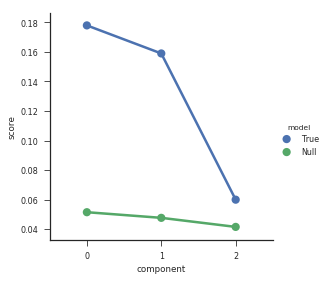

component 0: p = 0.002  ***
component 1: p = 0.002  ***
component 2: p = 0.004  ***
applying to test data


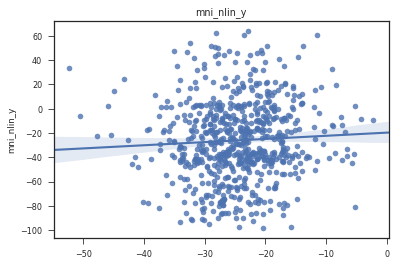

(0.05545231652425856, 0.1465255997031639)
26.35880213184118


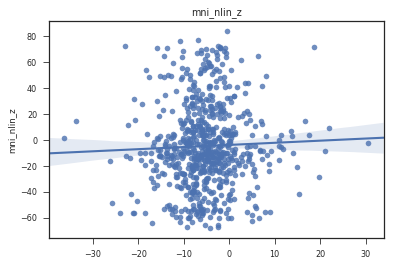

(0.035598658357792655, 0.35151154828248055)
25.821903907324703


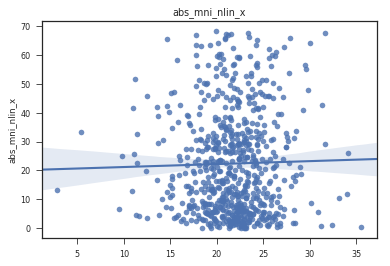

(0.021493668409398488, 0.573841586294461)
14.977091272413166


In [136]:
print('running PCA')
pcamod = PCA(n_components=100, random_state=123).fit(bigdf.values[gdf[gdf.slab_type=='CX'].index,:])
print('explained variance with PCA:',sum(pcamod.explained_variance_ratio_))
print('transforming and splitting')
pca_tfm = pandas.DataFrame(pcamod.transform(bigdf.values[gdf[gdf.slab_type=='CX'].index,:]))
tr,te = train_test_split(pca_tfm,random_state=123)
tr_y = gdf.loc[tr.index, ['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]
te_y = gdf.loc[te.index, ['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]
print('fitting model to training data')
pls_mod = PLSRegression(n_components=3)
# significant components?
print('evaluating output')
pls_mod.fit(tr,tr_y)
results, comp_sig = XD.evaluate_components(pls_mod, tr, tr_y)
# plot model fit
print('applying to test data')
te_pred = pls_mod.predict(te)
for i in range(te_y.shape[-1]):
    plt.close()
    sns.regplot(te_pred[:,i], te_y[te_y.columns[i]])
    plt.title(te_y.columns[i])
    plt.show()
    print(stats.pearsonr(te_pred[:,i], te_y[te_y.columns[i]]))
    print(mean_absolute_error(te_pred[:,i], te_y[te_y.columns[i]]))


running PCA
explained variance with PCA: 0.839794431874411
transforming and splitting
fitting model to training data
evaluating output
finished iteration 0
finished iteration 100
finished iteration 200
finished iteration 300
finished iteration 400


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning:

pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



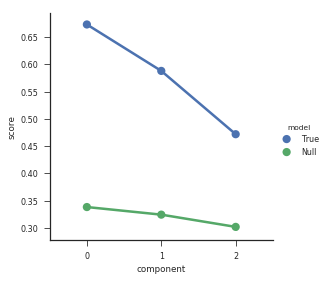

component 0: p = 0.002  ***
component 1: p = 0.002  ***
component 2: p = 0.002  ***
applying to test data


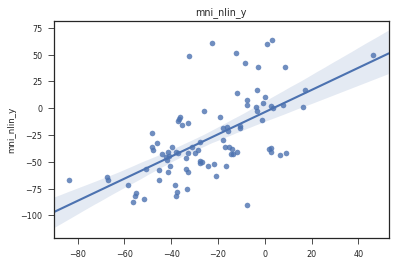

(0.6190757540472102, 4.778947762572875e-11)
21.985881780597452


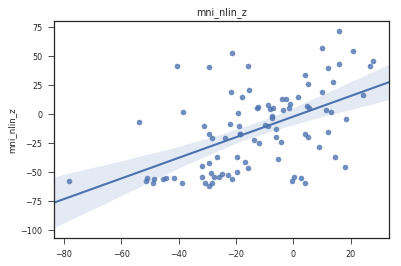

(0.5306763464344875, 5.2902455592508555e-08)
23.43669575193284


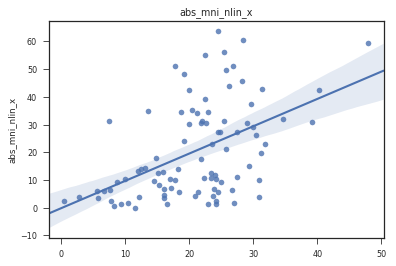

(0.4884775016928761, 7.818493608722346e-07)
11.721952789548151


In [127]:
print('running PCA')
pcamod = PCA(n_components=100, random_state=123).fit(bigdf.values[gdf[gdf.slab_type=='CB'].index,:])
print('explained variance with PCA:',sum(pcamod.explained_variance_ratio_))
print('transforming and splitting')
pca_tfm = pandas.DataFrame(pcamod.transform(bigdf.values[gdf[gdf.slab_type=='CB'].index,:]))
tr,te = train_test_split(pca_tfm,random_state=123)
tr_y = gdf.loc[tr.index, ['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]
te_y = gdf.loc[te.index, ['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]
print('fitting model to training data')
pls_mod = PLSRegression(n_components=3)
pls_mod.fit(tr,tr_y)
# significant components?
print('evaluating output')
results, comp_sig = XD.evaluate_components(pls_mod, tr, tr_y)
# plot model fit
print('applying to test data')
pls_mod.fit(tr,tr_y)
te_pred = pls_mod.predict(te)
for i in range(te_y.shape[-1]):
    plt.close()
    sns.regplot(te_pred[:,i], te_y[te_y.columns[i]])
    plt.title(te_y.columns[i])
    plt.show()
    print(stats.pearsonr(te_pred[:,i], te_y[te_y.columns[i]]))
    print(mean_absolute_error(te_pred[:,i], te_y[te_y.columns[i]]))


running PCA
explained variance with PCA: 0.7588259225998742
transforming and splitting
fitting model to training data
evaluating output
finished iteration 0
finished iteration 100
finished iteration 200
finished iteration 300
finished iteration 400


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning:

pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



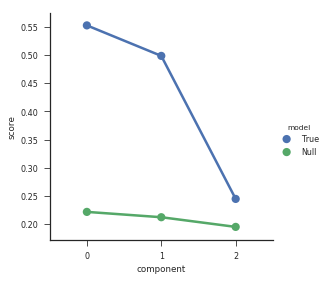

component 0: p = 0.002  ***
component 1: p = 0.002  ***
component 2: p = 0.018  ***
applying to test data


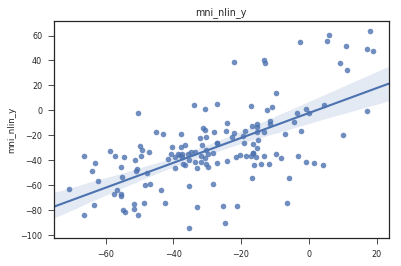

(0.6364295251072718, 4.599895736520842e-18)
18.691768417637032


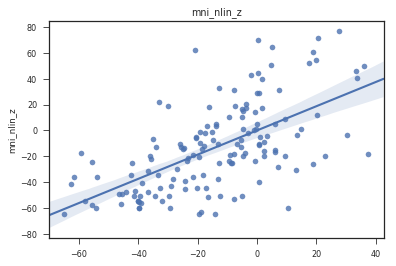

(0.6156612010958226, 1.0559165119599344e-16)
20.748597953420045


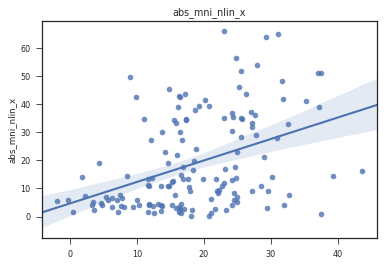

(0.41226818380475433, 2.1203702349414318e-07)
12.138839796742747


In [131]:
print('running PCA')
pcamod = PCA(n_components=100, random_state=123).fit(bigdf.values[gdf[gdf.slab_type=='BS'].index,:])
print('explained variance with PCA:',sum(pcamod.explained_variance_ratio_))
print('transforming and splitting')
pca_tfm = pandas.DataFrame(pcamod.transform(bigdf.values[gdf[gdf.slab_type=='BS'].index,:]))
tr,te = train_test_split(pca_tfm,random_state=123)
tr_y = gdf.loc[tr.index, ['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]
te_y = gdf.loc[te.index, ['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]
print('fitting model to training data')
pls_mod = PLSRegression(n_components=3)
pls_mod.fit(tr,tr_y)
# significant components?
print('evaluating output')
results, comp_sig = XD.evaluate_components(pls_mod, tr, tr_y)
# plot model fit
print('applying to test data')
pls_mod.fit(tr,tr_y)
te_pred = pls_mod.predict(te)
for i in range(te_y.shape[-1]):
    plt.close()
    sns.regplot(te_pred[:,i], te_y[te_y.columns[i]])
    plt.title(te_y.columns[i])
    plt.show()
    print(stats.pearsonr(te_pred[:,i], te_y[te_y.columns[i]]))
    print(mean_absolute_error(te_pred[:,i], te_y[te_y.columns[i]]))


#### now again with PCA from whole brain

In [ ]:
pcamod = PCA(n_components=100, random_mstate=123).fit(bigdf)
sum(pcamod.explained_variance_ratio_)

transforming and splitting
fitting model to training data
evaluating output
finished iteration 0
finished iteration 100
finished iteration 200
finished iteration 300
finished iteration 400


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning:

pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



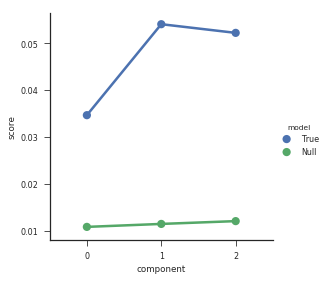

component 0: p = 0.002  ***
component 1: p = 0.002  ***
component 2: p = 0.002  ***
applying to test data


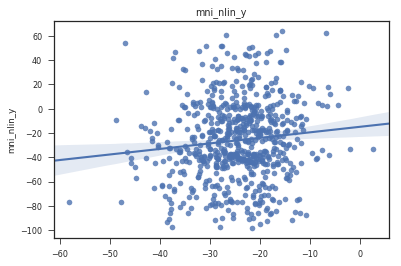

(0.10862421280089836, 0.004366860294814503)
25.806700419278716


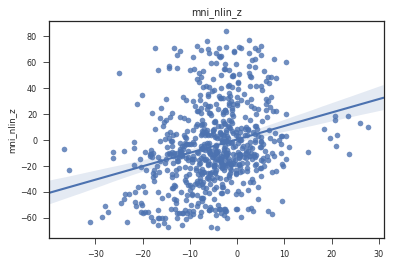

(0.268655395940062, 8.016330829507653e-13)
24.52041851942704


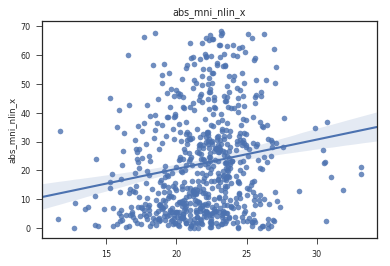

(0.17393120005187748, 4.527929830752275e-06)
14.445150630377585


In [132]:
print('transforming and splitting')
pca_tfm = pandas.DataFrame(pcamod.transform(bigdf.values[gdf[gdf.slab_type=='CX'].index,:]))
tr,te = train_test_split(pca_tfm,random_state=123)
tr_y = gdf.loc[tr.index, ['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]
te_y = gdf.loc[te.index, ['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]
print('fitting model to training data')
pls_mod = PLSRegression(n_components=3)
pls_mod.fit(tr,tr_y)
# significant components?
print('evaluating output')
results, comp_sig = XD.evaluate_components(pls_mod, tr, tr_y)
pls_mod.fit(tr,tr_y)
# plot model fit
print('applying to test data')
te_pred = pls_mod.predict(te)
for i in range(te_y.shape[-1]):
    plt.close()
    sns.regplot(te_pred[:,i], te_y[te_y.columns[i]])
    plt.title(te_y.columns[i])
    plt.show()
    print(stats.pearsonr(te_pred[:,i], te_y[te_y.columns[i]]))
    print(mean_absolute_error(te_pred[:,i], te_y[te_y.columns[i]]))


transforming and splitting
fitting model to training data
evaluating output
finished iteration 0
finished iteration 100
finished iteration 200
finished iteration 300
finished iteration 400


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning:

pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



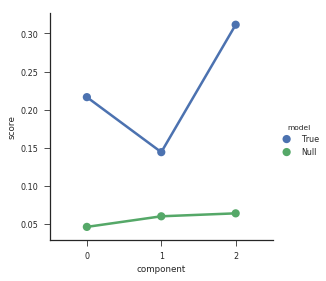

component 0: p = 0.002  ***
component 1: p = 0.002  ***
component 2: p = 0.002  ***
applying to test data


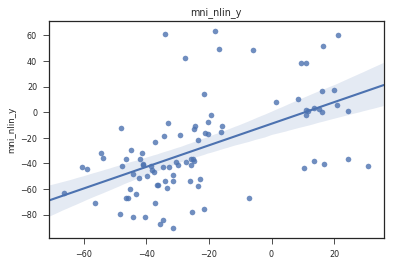

(0.5449487056586358, 1.952352111026992e-08)
23.61088432210747


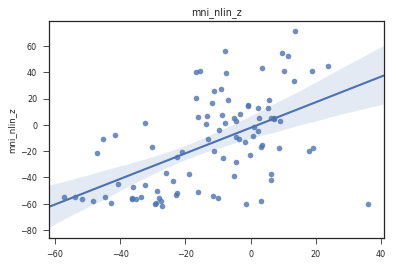

(0.5413947472184221, 2.5133010087729592e-08)
23.493742393243664


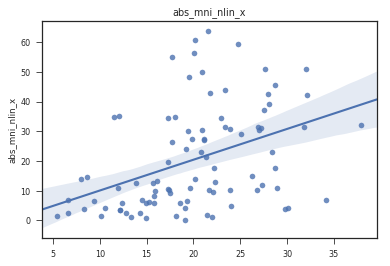

(0.41428888683916165, 4.035230870712537e-05)
12.35579878376688


In [134]:
print('transforming and splitting')
pca_tfm = pandas.DataFrame(pcamod.transform(bigdf.values[gdf[gdf.slab_type=='CB'].index,:]))
tr,te = train_test_split(pca_tfm,random_state=123)
tr_y = gdf.loc[tr.index, ['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]
te_y = gdf.loc[te.index, ['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]
print('fitting model to training data')
pls_mod = PLSRegression(n_components=3)
pls_mod.fit(tr,tr_y)
# significant components?
print('evaluating output')
results, comp_sig = XD.evaluate_components(pls_mod, tr, tr_y)
pls_mod.fit(tr,tr_y)
# plot model fit
print('applying to test data')
te_pred = pls_mod.predict(te)
for i in range(te_y.shape[-1]):
    plt.close()
    sns.regplot(te_pred[:,i], te_y[te_y.columns[i]])
    plt.title(te_y.columns[i])
    plt.show()
    print(stats.pearsonr(te_pred[:,i], te_y[te_y.columns[i]]))
    print(mean_absolute_error(te_pred[:,i], te_y[te_y.columns[i]]))


transforming and splitting
fitting model to training data
evaluating output
finished iteration 0
finished iteration 100
finished iteration 200
finished iteration 300
finished iteration 400


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning:

pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



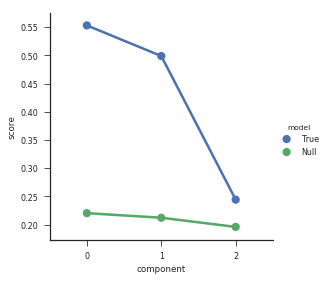

component 0: p = 0.002  ***
component 1: p = 0.002  ***
component 2: p = 0.028  ***
applying to test data


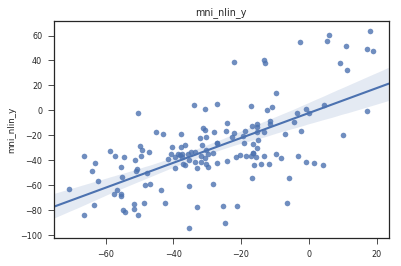

(0.6364295251072718, 4.599895736520842e-18)
18.691768417637032


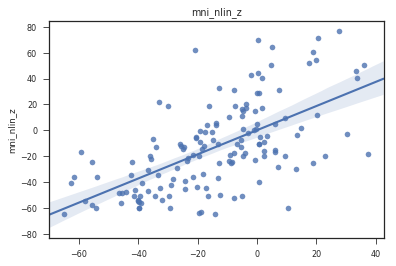

(0.6156612010958226, 1.0559165119599344e-16)
20.748597953420045


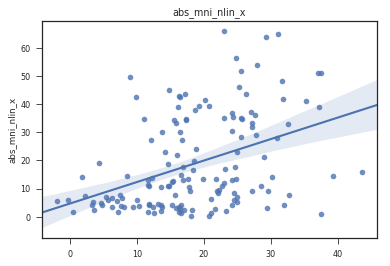

(0.41226818380475433, 2.1203702349414318e-07)
12.138839796742747


In [135]:
print('transforming and splitting')
pca_tfm = pandas.DataFrame(pcamod.transform(bigdf.values[gdf[gdf.slab_type=='BS'].index,:]))
tr,te = train_test_split(pca_tfm,random_state=123)
tr_y = gdf.loc[tr.index, ['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]
te_y = gdf.loc[te.index, ['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]
print('fitting model to training data')
pls_mod = PLSRegression(n_components=3)
pls_mod.fit(tr,tr_y)
# significant components?
print('evaluating output')
results, comp_sig = XD.evaluate_components(pls_mod, tr, tr_y)
pls_mod.fit(tr,tr_y)
# plot model fit
print('applying to test data')
te_pred = pls_mod.predict(te)
for i in range(te_y.shape[-1]):
    plt.close()
    sns.regplot(te_pred[:,i], te_y[te_y.columns[i]])
    plt.title(te_y.columns[i])
    plt.show()
    print(stats.pearsonr(te_pred[:,i], te_y[te_y.columns[i]]))
    print(mean_absolute_error(te_pred[:,i], te_y[te_y.columns[i]]))


# Understanding the components

In [198]:
Medulla = ['arcuate nucleus of medulla, left','arcuate nucleus of medulla, right',
                 'central glial substance',
                 'central medullary reticular group, left','central medullary reticular group, right',
                 'cochlear nuclei, left','cochlear nuclei, right',
                 'cuneate nucleus, left','cuneate nucleus, right',
                 'dorsal motor nucleus of the vagus, left','dorsal motor nucleus of the vagus, right',
                 'gigantocellular group, left','gigantocellular group, right',
                 'gracile nucleus, left','gracile nucleus, right',
                 'hypoglossal nucleus, left','hypoglossal nucleus, right',
                 'inferior olivary complex, left','inferior olivary complex, right',
                 'lateral medullary reticular group, left','lateral medullary reticular group, right',
                 'raphe nuclei of medulla',
                 'spinal trigeminal nucleus, left','spinal trigeminal nucleus, right',
                 'superior olivary complex, left','superior olivary complex, right',
                 'vestibular nuclei, left','vestibular nuclei, right']

Pons =          ['abducens nucleus, left','abducens nucleus, right',
                 'central gray of the pons, left','central gray of the pons, right',
                 'facial motor nucleus, left','facial motor nucleus, right',
                 'lateral parabrachial nucleus, left','lateral parabrachial nucleus, right',
                 'locus ceruleus, left','locus ceruleus, right',
                 'medial parabrachial nucleus, left','medial parabrachial nucleus, right',
                 'medial parabrachial nucleus,right',
                 'motor nucleus of trigeminal nerve, left','motor nucleus of trigeminal nerve, right',
                 'nucleus subceruleus, left','nucleus subceruleus, right',
                 'pontine nuclei, left','pontine nuclei, right',
                 'pontine raphe nucleus','pontine raphe nucleus, left',
                 'pontine reticular formation, left','pontine reticular formation, right',
                 'principal sensory nucleus of trigeminal nerve, left','principal sensory nucleus of trigeminal nerve, right',
                 ]

DCN = ['dentate nucleus, left',
       'dentate nucleus, right',
       'emboliform nucleus, left',
       'emboliform nucleus, right',
       'fastigial nucleus, left',
       'fastigial nucleus, right',
       'globose nucleus, left',
       'globose nucleus, right']

Cerebellum = [x for x in gdf[gdf.slab_type=='CB']['structure_name'].unique().tolist() if x not in DCN]

Tectum = ['inferior colliculus, left',
          'superior colliculus, left','superior colliculus, right',
          'pretectal region']

Tegmentum = ['central gray substance of midbrain, left','central gray substance of midbrain, right',
            'cuneiform nucleus, left','cuneiform nucleus, right',
            'Edinger-Westphal nucleus, left','Edinger-Westphal nucleus, right',
            'interstitial nucleus of Cajal, left','interstitial nucleus of Cajal, right',
            'midbrain raphe nuclei','midbrain raphe nuclei, left',
            'midbrain reticular formation, left','midbrain reticular formation, right',
            'nucleus of Darkschewitsch, left',
            'oculomotor nuclear complex, right','oculomotor nuclear complex, left',
            'red nucleus, left','red nucleus, right',
            'subcuneiform nucleus, left','subcuneiform nucleus, right',
            'substantia nigra, pars compacta, left','substantia nigra, pars compacta, right',
            'substantia nigra, pars reticulata, left','substantia nigra, pars reticulata, right',
            'trochlear nucleus, left','trochlear nucleus, right',
            'ventral tegmental area, left','ventral tegmental area, right']

Hypothalamus = ['anterior hypothalamic area, left','anterior hypothalamic area, right',
               'arcuate nucleus of the hypothalamus, left','arcuate nucleus of the hypothalamus, right',
               'dorsomedial hypothalamic nucleus, left',
               'lateral hypothalamic area, anterior region, left', 'lateral hypothalamic area, anterior region, right',
               'lateral hypothalamic area, mammillary region, left', 'lateral hypothalamic area, mammillary region, right',
               'lateral hypothalamic area, tuberal region, left',
               'paraventricular nucleus of the hypothalamus, left','paraventricular nucleus of the hypothalamus, right',
               'perifornical nucleus, left',
               'posterior hypothalamic area, left','posterior hypothalamic area, right',
               'preoptic region, left','preoptic region, right',
               'supraoptic nucleus, left','supraoptic nucleus, right',
               'ventromedial hypothalamic nucleus, left','ventromedial hypothalamic nucleus, right',]
                

Thalamus = ['anterior group of nuclei, left','anterior group of nuclei, right',
           'caudal group of intralaminar nuclei, left','caudal group of intralaminar nuclei, right',
           'dorsal lateral geniculate nucleus, left','dorsal lateral geniculate nucleus, right',
           'lateral group of nuclei, left, dorsal division','lateral group of nuclei, left, ventral division',
           'lateral group of nuclei, right, dorsal division','lateral group of nuclei, right, ventral division',
           'medial geniculate complex, left','medial geniculate complex, right',
           'medial group of nuclei, left','medial group of nuclei, right',
           'reticular nucleus of thalamus, left','reticular nucleus of thalamus, right',
           'rostral group of intralaminar nuclei, left','rostral group of intralaminar nuclei, right',
           'paraventricular nuclei, left of thalamus, left','paraventricular nuclei, right of thalamus, right',
           'posterior group of nuclei, left','posterior group of nuclei, right',
           'subthalamic nucleus, left','subthalamic nucleus, right',
           'zona incerta, left','zona incerta, right']

Other_Dien = ['lateral habenular nucleus, left','lateral habenular nucleus, right',
             'lateral mammillary nucleus, left',
             'lateral tuberal nucleus, left',
             'mammillary body, left','mammillary body, right',
             'medial habenular nucleus, left','medial habenular nucleus, right',
             'medial mammillary nucleus, left',
             'pallidohypothalamic nucleus, left',
             'pineal gland',
             'supramammillary nucleus, left',
             'tuberomammillary nucleus, left']

Limbic = ['CA1 field, left','CA1 field, right',
          'CA2 field, left','CA2 field, right',
          'CA3 field, left','CA3 field, right',
          'CA4 field, left','CA4 field, right',
          'amygdalohippocampal transition zone, left',
          'amygdalohippocampal transition zone, right',
          'basolateral nucleus, left','basolateral nucleus, right',
          'basomedial nucleus, left','basomedial nucleus, right',
          'central nucleus, left','central nucleus, right',
          'cortico-medial group, left','cortico-medial group, right',
          'dentate gyrus, left','dentate gyrus, right',
          'lateral nucleus, left','lateral nucleus, right',
          'septal nuclei, left','septal nuclei, right',
         'subiculum, left','subiculum, right']

Forebrain = ['basal nucleus of meynert, left','basal nucleus of meynert, right',
            'nucleus accumbens, left','nucleus accumbens, right',
            'nucleus of the diagonal band, left, horizontal division',
            'nucleus of the diagonal band, left, vertical division',
            'olfactory tubercle, left', 'piriform cortex, left',
            'substantia innominata, left','substantia innominata, right']

Striatum = ['bed  nucleus of stria terminalis, left',
            'body of caudate nucleus, left',
            'body of caudate nucleus, right',
            'globus pallidus, external segment, left','globus pallidus, external segment, right',
            'globus pallidus, internal segment, left','globus pallidus, internal segment, right',
            'head of caudate nucleus, left','head of caudate nucleus, right',
            'olfactory tubercle, left',
            'putamen, left','putamen, right',
           'tail of caudate nucleus, left','tail of caudate nucleus, right']

Anterior_Cingulate = ['cingulate gyrus, frontal part, left, inferior bank of gyrus',
                     'cingulate gyrus, frontal part, left, superior bank of gyrus',
                     'cingulate gyrus, frontal part, right, inferior bank of gyrus',
                     'cingulate gyrus, frontal part, right, superior bank of gyrus',
                     'paraterminal gyrus, right',
                     'parolfactory gyri, left','parolfactory gyri, right',
                     'subcallosal cingulate gyrus, left','subcallosal cingulate gyrus, right']

Posterior_Cingulate = ['cingulate gyrus, parietal part, left, inferior bank of gyrus',
                     'cingulate gyrus, parietal part, left, superior bank of gyrus',
                     'cingulate gyrus, parietal part, right, inferior bank of gyrus',
                     'cingulate gyrus, parietal part, right, superior bank of gyrus',
                     'cingulate gyrus, retrosplenial part, left, inferior bank of gyrus',
                     'cingulate gyrus, retrosplenial part, left, superior bank of gyrus',
                     'cingulate gyrus, retrosplenial part, right, inferior bank of gyrus',
                     'cingulate gyrus, retrosplenial part, right, superior bank of gyrus',]

Insula = ['claustrum, left','claustrum, right',
         'long insular gyri, left','long insular gyri, right',
         'short insular gyri, left','short insular gyri, right',]

Temporal = ["Heschl's gyrus, left", "Heschl's gyrus, right",
           'fusiform gyrus, left, bank of cos','fusiform gyrus, left, bank of the its',
           'fusiform gyrus, left, lateral bank of gyrus','fusiform gyrus, right, bank of cos',
           'fusiform gyrus, right, bank of the its','fusiform gyrus, right, lateral bank of gyrus',
           'inferior temporal gyrus, left, bank of mts','inferior temporal gyrus, left, bank of the its',
           'inferior temporal gyrus, left, lateral bank of gyrus','inferior temporal gyrus, right, bank of mts',
           'inferior temporal gyrus, right, bank of the its','inferior temporal gyrus, right, lateral bank of gyrus',
           'middle temporal gyrus, left, inferior bank of gyrus','middle temporal gyrus, left, superior bank of gyrus',
           'middle temporal gyrus, right, inferior bank of gyrus','middle temporal gyrus, right, superior bank of gyrus',
           'occipito-temporal gyrus, left, inferior bank of gyrus','occipito-temporal gyrus, left, superior bank of gyrus',
           'occipito-temporal gyrus, right, inferior bank of gyrus','occipito-temporal gyrus, right, superior bank of gyrus',
           'parahippocampal gyrus, left, bank of the cos','parahippocampal gyrus, left, lateral bank of gyrus',
           'parahippocampal gyrus, right, bank of the cos','parahippocampal gyrus, right, lateral bank of gyrus',
           'superior temporal gyrus, left, inferior bank of gyrus','superior temporal gyrus, left, lateral bank of gyrus',
           'superior temporal gyrus, right, inferior bank of gyrus','superior temporal gyrus, right, lateral bank of gyrus',
           'temporal pole, left, inferior aspect','temporal pole, left, medial aspect',
           'temporal pole, left, superior aspect','temporal pole, right, inferior aspect',
           'temporal pole, right, medial aspect','temporal pole, right, superior aspect',
           'transverse gyri, left','transverse gyri, right',
           'planum polare, left','planum polare, right',
           'planum temporale, left','planum temporale, right']

Parietal = ['angular gyrus, left, inferior bank of gyrus','angular gyrus, left, superior bank of gyrus',
            'angular gyrus, right, inferior bank of gyrus','angular gyrus, right, superior bank of gyrus',
            'precuneus, left, inferior lateral bank of gyrus','precuneus, left, superior lateral bank of gyrus',
            'precuneus, right, inferior lateral bank of gyrus','precuneus, right, superior lateral bank of gyrus',
            'superior parietal lobule, left, inferior bank of gyrus','superior parietal lobule, left, superior bank of gyrus',
            'superior parietal lobule, right, inferior bank of gyrus','superior parietal lobule, right, superior bank of gyrus',
            'supramarginal gyrus, left, inferior bank of gyrus','supramarginal gyrus, left, superior bank of gyrus',
            'supramarginal gyrus, right, inferior bank of gyrus','supramarginal gyrus, right, superior bank of gyrus']

Frontal = ['anterior orbital gyrus, left','anterior orbital gyrus, right',
           'arcuate nucleus of the hypothalamus, left','arcuate nucleus of the hypothalamus, right',
          'frontal operculum, left','frontal operculum, right',
          'frontal pole, left, inferior aspect','frontal pole, left, medial aspect',
          'frontal pole, left, superior aspect','frontal pole, right, inferior aspect',
          'frontal pole, right, medial aspect','frontal pole, right, superior aspect',
          'gyrus rectus, left','gyrus rectus, right',
          'inferior frontal gyrus, opercular part, left','inferior frontal gyrus, opercular part, right',
          'inferior frontal gyrus, orbital part, left','inferior frontal gyrus, orbital part, right',
          'inferior frontal gyrus, triangular part, left','inferior frontal gyrus, triangular part, right',
          'inferior rostral gyrus, left','inferior rostral gyrus, right',
          'lateral orbital gyrus, left','lateral orbital gyrus, right',
          'medial orbital gyrus, left','medial orbital gyrus, right',
          'middle frontal gyrus, left, inferior bank of gyrus','middle frontal gyrus, left, superior bank of gyrus',
          'middle frontal gyrus, right, inferior bank of gyrus','middle frontal gyrus, right, superior bank of gyrus',
          'posterior orbital gyrus, left','posterior orbital gyrus, right',
          'superior frontal gyrus, left','superior frontal gyrus, left, lateral bank of gyrus',
          'superior frontal gyrus, left, medial bank of gyrus','superior frontal gyrus, right, lateral bank of gyrus',
          'superior frontal gyrus, right, medial bank of gyrus',
          'superior rostral gyrus, left','superior rostral gyrus, right']

Occipital = ['cuneus, left, peristriate',
             'cuneus, left, striate',
             'cuneus, right, peristriate',
             'cuneus, right, striate',
             'inferior occipital gyrus, left, inferior bank of gyrus','inferior occipital gyrus, left, superior bank of gyrus',
             'inferior occipital gyrus, right, inferior bank of gyrus','inferior occipital gyrus, right, superior bank of gyrus',
             'lingual gyrus, left, peristriate','lingual gyrus, left, striate',
             'lingual gyrus, right, peristriate','lingual gyrus, right, striate',
             'occipital pole, left, inferior aspect',
             'occipital pole, left, lateral aspect','occipital pole, left, superior aspect',
             'superior occipital gyrus, left, inferior bank of gyrus','superior occipital gyrus, left, superior bank of gyrus',
             'superior occipital gyrus, right, inferior bank of gyrus','superior occipital gyrus, right, superior bank of gyrus',]

Sensorimotor = ['paracentral lobule, anterior part, left','paracentral lobule, anterior part, left, inferior bank of gyrus',
                'paracentral lobule, anterior part, left, superior bank of gyrus','paracentral lobule, anterior part, right, inferior bank of gyrus',
                'paracentral lobule, anterior part, right, superior bank of gyrus','paracentral lobule, posterior part, left, bank of cingulate sulcus',
                'paracentral lobule, posterior part, left, lateral bank of gyrus','paracentral lobule, posterior part, right, bank of cingulate sulcus',
                'paracentral lobule, posterior part, right, lateral bank of gyrus',
                'postcentral gyrus, left, bank of the central sulcus','postcentral gyrus, left, bank of the posterior central sulcus',
                'postcentral gyrus, left, inferior lateral aspect of gyrus','postcentral gyrus, left, superior lateral aspect of gyrus',
                'postcentral gyrus, right, bank of the central sulcus','postcentral gyrus, right, bank of the posterior central sulcus',
                'postcentral gyrus, right, inferior lateral aspect of gyrus','postcentral gyrus, right, superior lateral aspect of gyrus',
                'precentral gyrus, left, bank of the central sulcus','precentral gyrus, left, bank of the precentral sulcus',
                'precentral gyrus, left, inferior lateral aspect of gyrus','precentral gyrus, left, superior lateral aspect of gyrus',
                'precentral gyrus, right, bank of the central sulcus','precentral gyrus, right, bank of the precentral sulcus',
                'precentral gyrus, right, inferior lateral aspect of gyrus','precentral gyrus, right, superior lateral aspect of gyrus']
            
divs = [Medulla, Pons, DCN, Cerebellum, Tectum, Tegmentum, Hypothalamus, Thalamus, Other_Dien,
                  Limbic, Forebrain, Striatum, Anterior_Cingulate, Posterior_Cingulate, Insula,
                  Temporal, Frontal, Parietal, Occipital, Sensorimotor]
names = ['Medulla', 'Pons', 'DCN', 'Cerebellum', 'Tectum', 'Tegmentum', 'Hypothalamus', 'Thalamus', 
         'Other_Dien', 'Limbic', 'Forebrain', 'Striatum', 'Anterior_Cingulate', 'Posterior_Cingulate', 
         'Insula', 'Temporal', 'Frontal', 'Parietal', 'Occipital', 'Sensorimotor']
brain_division = dict(zip(names,divs))

for name, div in brain_division.items():
    gdf.loc[gdf[gdf.structure_name.isin(div)].index,'brain_divison'] = name
    

In [200]:
# For C1
Meyelencephalon = Medulla[:] 
Metencelphalon = Pons + DCN + Cerebellum
Mesencephalon = Tectum + Tegmentum
Diencephalon = Hypothalamus + Thalamus + Other_Dien
Telencephalon = Limbic + Forebrain + Striatum + Anterior_Cingulate + Posterior_Cingulate +\
                Insula + Temporal + Frontal + Parietal + Occipital + Sensorimotor

divs = [Meyelencephalon, Metencelphalon, Mesencephalon, Diencephalon, Telencephalon]
names = ['Meyelencephalon', 'Metencelphalon', 'Mesencephalon', 'Diencephalon', 'Telencephalon']
brain_division = dict(zip(names,divs))

for name, div in brain_division.items():
    gdf.loc[gdf[gdf.structure_name.isin(div)].index,'Neural_Tube_segment'] = name
    

In [333]:
# For C3

Auditory = ["Heschl's gyrus, left", "Heschl's gyrus, right",
            'planum polare, left','planum polare, right',
            'planum temporale, left','planum temporale, right',
            'transverse gyri, left','transverse gyri, right']
Visual = ['cuneus, left, peristriate','cuneus, left, striate',
                 'cuneus, right, peristriate','cuneus, right, striate',
                 'lingual gyrus, left, peristriate','lingual gyrus, left, striate',
                 'lingual gyrus, right, peristriate','lingual gyrus, right, striate']
Olfactory = ['olfactory tubercle, left', 'piriform cortex, left']


Sensory_Cortex = Sensorimotor + Auditory + Visual + Olfactory
gdf.loc[gdf[gdf.structure_name.isin(Sensory_Cortex)].index,'Cortical_Type'] = 'Sensory'

Association_Cortex = [x for x in Telencephalon if x not in Striatum and x not in Sensory_Cortex]
gdf.loc[gdf[gdf.structure_name.isin(Association_Cortex)].index,'Cortical_Type'] = 'Association_Cortex'

Not_Cortex = Meyelencephalon + Mesencephalon + Metencelphalon + Diencephalon + Striatum
gdf.loc[gdf[gdf.structure_name.isin(Not_Cortex)].index,'Cortical_Type'] = 'Not Cortex'


divs = [Auditory, Visual, Olfactory, Sensorimotor, Association_Cortex, Not_Cortex]
names = ['Auditory','Visual','Olfactory','Sensorimotor','Association_Cortex','Not_Cortex']
brain_division = dict(zip(names,divs))
for name, div in brain_division.items():
    gdf.loc[gdf[gdf.structure_name.isin(div)].index,'Sensory_Type'] = name


In [302]:
gdf.to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/MAIN_gcx_wholebrain_info_W_BRAIN_DIVISIONS.csv')

In [344]:
code = dict(zip(gdf.Neural_Tube_segment.unique().tolist(),
               range(len(gdf.Neural_Tube_segment.unique().tolist()))))
labs = [code[x] if pandas.notnull(x) else 999 for x in gdf.Neural_Tube_segment.values]
embedding = gdf[['abs_mni_nlin_x','mni_nlin_y','mni_nlin_z']].values

lmap = {v: k for k, v in code.items()}
lmap.pop(5)
lmap.update({999: 'NaN'})
traces = list()
for lab in np.unique(labs):
    l_index = [x for x in range(len(labs)) if labs[x] == lab]
    l_embed = embedding[l_index]
#     color_str = str(int('0x' + color_dict[lab][1:3].upper(),16)) + ',' + \
#                    str(int('0x' + color_dict[lab][3:5].upper(),16)) + ',' + \
#                    str(int('0x' + color_dict[lab][5:7].upper(),16))
    #color_str = plt.cm.tab10.colors[lab]
    color_str = 'rgba %s'%str(tuple([x - 0.0000001 for x in plt.cm.tab10(lab) if x > 0]))
    temp_trace = plotly.graph_objs.Scatter3d(x=l_embed[:,0],
                                            y = l_embed[:,1],
                                            z = l_embed[:,2],
                                            name = lmap[lab],
                                            mode = 'markers',
                                            marker = dict(size=3,
                                                          color=color_str
                                                         )
                                            )
    traces.append(temp_trace)

layout = plotly.graph_objs.Layout(margin = dict(l=0,r=0,b=0,t=0))

fig = plotly.graph_objs.Figure(data=traces, layout=layout)
plotly.offline.plot(fig, 
                    filename='/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ADDX/NT_brain.html')
    

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/subprocess.py:761: ResourceWarning:

subprocess 19355 is still running



'file:///home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ADDX/NT_brain.html'

In [345]:
code = dict(zip(gdf.Neural_Tube_segment.unique().tolist(),
               range(len(gdf.Neural_Tube_segment.unique().tolist()))))
labs = [code[x] if pandas.notnull(x) else 999 for x in gdf.Neural_Tube_segment.values]
embedding = preds_df[['predicted_x','predicted_y','predicted_z']].values

lmap = {v: k for k, v in code.items()}
lmap.pop(5)
lmap.update({999: 'NaN'})
traces = list()
for lab in np.unique(labs):
    l_index = [x for x in range(len(labs)) if labs[x] == lab]
    l_embed = embedding[l_index]
#     color_str = str(int('0x' + color_dict[lab][1:3].upper(),16)) + ',' + \
#                    str(int('0x' + color_dict[lab][3:5].upper(),16)) + ',' + \
#                    str(int('0x' + color_dict[lab][5:7].upper(),16))
    #color_str = plt.cm.tab10.colors[lab]
    color_str = 'rgba %s'%str(tuple([x - 0.0000001 for x in plt.cm.tab10(lab) if x > 0]))
    temp_trace = plotly.graph_objs.Scatter3d(x=l_embed[:,0],
                                            y = l_embed[:,1],
                                            z = l_embed[:,2],
                                            name = lmap[lab],
                                            mode = 'markers',
                                            marker = dict(size=3,
                                                          color=color_str
                                                         )
                                            )
    traces.append(temp_trace)

layout = plotly.graph_objs.Layout(margin = dict(l=0,r=0,b=0,t=0))

fig = plotly.graph_objs.Figure(data=traces, layout=layout)
plotly.offline.plot(fig, 
                    filename='/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ADDX/NT_brain_predicted.html')
    

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/subprocess.py:761: ResourceWarning:

subprocess 19407 is still running



'file:///home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ADDX/NT_brain_predicted.html'

In [346]:
code = dict(zip(gdf.brain_divison.unique().tolist(),
               range(len(gdf.brain_divison.unique().tolist()))))
labs = [code[x] if pandas.notnull(x) else 999 for x in gdf.brain_divison.values]
embedding = gdf[['abs_mni_nlin_x','mni_nlin_y','mni_nlin_z']].values

lmap = {v: k for k, v in code.items()}
lmap.pop(19)
lmap.update({999: 'NaN'})
traces = list()
for lab in np.unique(labs):
    l_index = [x for x in range(len(labs)) if labs[x] == lab]
    l_embed = embedding[l_index]
#     color_str = str(int('0x' + color_dict[lab][1:3].upper(),16)) + ',' + \
#                    str(int('0x' + color_dict[lab][3:5].upper(),16)) + ',' + \
#                    str(int('0x' + color_dict[lab][5:7].upper(),16))
    #color_str = plt.cm.tab10.colors[lab]
    color_str = 'rgba %s'%str(tuple([x - 0.0000001 for x in plt.cm.tab20(lab) if x > 0]))
    temp_trace = plotly.graph_objs.Scatter3d(x=l_embed[:,0],
                                            y = l_embed[:,1],
                                            z = l_embed[:,2],
                                            name = lmap[lab],
                                            mode = 'markers',
                                            marker = dict(size=3,
                                                          color=color_str
                                                         )
                                            )
    traces.append(temp_trace)

layout = plotly.graph_objs.Layout(margin = dict(l=0,r=0,b=0,t=0))

fig = plotly.graph_objs.Figure(data=traces, layout=layout)
plotly.offline.plot(fig, 
                    filename='/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ADDX/brain.html')
    

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/subprocess.py:761: ResourceWarning:

subprocess 19435 is still running



'file:///home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ADDX/brain.html'

In [347]:
code = dict(zip(gdf.brain_divison.unique().tolist(),
               range(len(gdf.brain_divison.unique().tolist()))))
labs = [code[x] if pandas.notnull(x) else 999 for x in gdf.brain_divison.values]
embedding = preds_df[['predicted_x','predicted_y','predicted_z']].values

lmap = {v: k for k, v in code.items()}
lmap.pop(19)
lmap.update({999: 'NaN'})
traces = list()
for lab in np.unique(labs):
    l_index = [x for x in range(len(labs)) if labs[x] == lab]
    l_embed = embedding[l_index]
#     color_str = str(int('0x' + color_dict[lab][1:3].upper(),16)) + ',' + \
#                    str(int('0x' + color_dict[lab][3:5].upper(),16)) + ',' + \
#                    str(int('0x' + color_dict[lab][5:7].upper(),16))
    #color_str = plt.cm.tab10.colors[lab]
    color_str = 'rgba %s'%str(tuple([x - 0.0000001 for x in plt.cm.tab20(lab) if x > 0]))
    temp_trace = plotly.graph_objs.Scatter3d(x=l_embed[:,0],
                                            y = l_embed[:,1],
                                            z = l_embed[:,2],
                                            name = lmap[lab],
                                            mode = 'markers',
                                            marker = dict(size=3,
                                                          color=color_str
                                                         )
                                            )
    traces.append(temp_trace)

layout = plotly.graph_objs.Layout(margin = dict(l=0,r=0,b=0,t=0))

fig = plotly.graph_objs.Figure(data=traces, layout=layout)
plotly.offline.plot(fig, 
                    filename='/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ADDX/brain_predicted.html')
    

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/subprocess.py:761: ResourceWarning:

subprocess 19487 is still running



'file:///home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ADDX/brain_predicted.html'

In [206]:
gdf.loc[:,'Component1_Expresion'] = c1_xp
gdf.loc[:,'Component2_Expresion'] = c2_xp
gdf.loc[:,'Component3_Expresion'] = c3_xp


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning:

pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



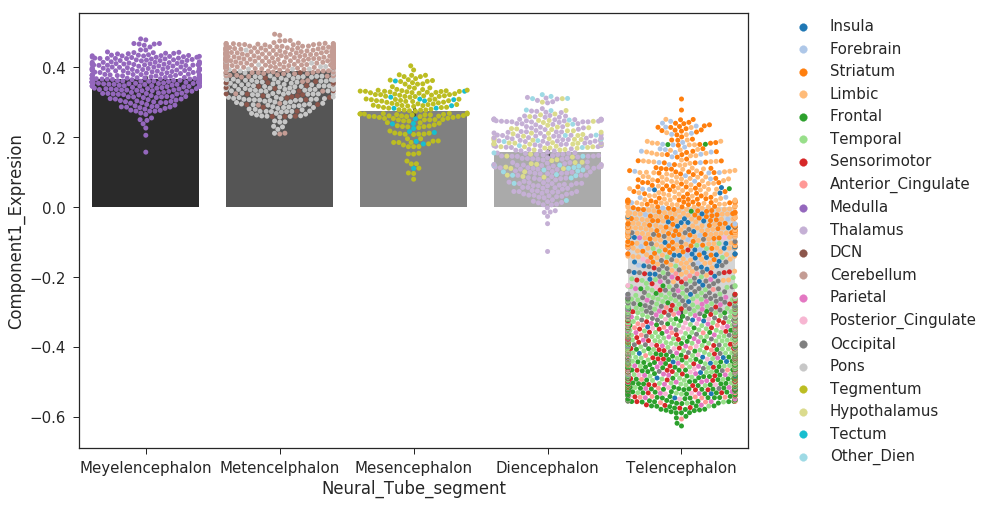

In [314]:
sns.set_context('notebook',font_scale=1.5)
plt.subplots(figsize=(12,8))
order = ['Meyelencephalon', 'Metencelphalon', 'Mesencephalon', 'Diencephalon', 'Telencephalon']
sns.barplot(x='Neural_Tube_segment', y='Component1_Expresion', data=gdf,palette='gray',
           order = order)
sns.swarmplot(x='Neural_Tube_segment', y='Component1_Expresion', data=gdf, hue='brain_divison',
              order = order, palette='tab20')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ADDX/C1_NT.pdf',
           bbox_inches='tight')

In [236]:
bsn = []
for x in gdf.structure_name.values:
    if ',' in x:
        bsn.append(x.split(',')[0])
    else:
        bsn.append(x)
gdf.loc[:,'bilateral_structure_name'] = bsn

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning:

pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



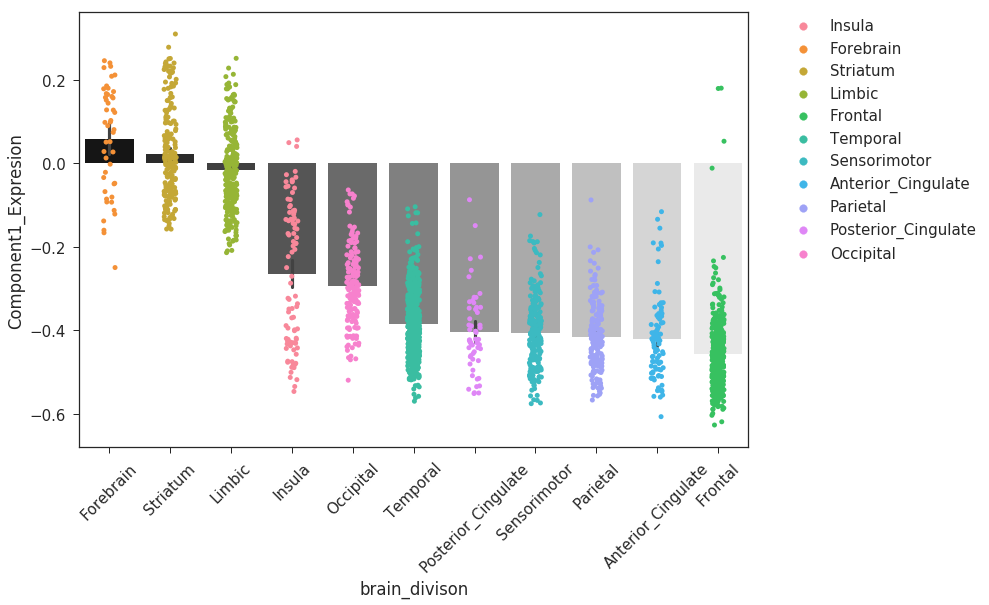

In [349]:
plt.subplots(figsize=(12,8))
order = ['Forebrain', 'Striatum', 'Limbic', 'Insula', 'Occipital',
        'Temporal','Posterior_Cingulate','Sensorimotor','Parietal',
        'Anterior_Cingulate','Frontal']
g=sns.barplot(x='brain_divison', y='Component1_Expresion', order = order,
            data=gdf[gdf.Neural_Tube_segment=='Telencephalon'], palette='gray',
           )
h=sns.stripplot(x='brain_divison', y='Component1_Expresion', order=order,jitter=True,
              hue='brain_divison',
            data=gdf[gdf.Neural_Tube_segment=='Telencephalon'],
           )
for item in h.get_xticklabels():
    item.set_rotation(45)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ADDX/C1_Tele.pdf',
           bbox_inches='tight')

In [332]:
gdf.Sensory_Type.value_counts()

Association_Cortex    1738
Sensorimotor           216
Visual                 109
Auditory                60
Olfactory                8
Name: Sensory_Type, dtype: int64

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning:

pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead



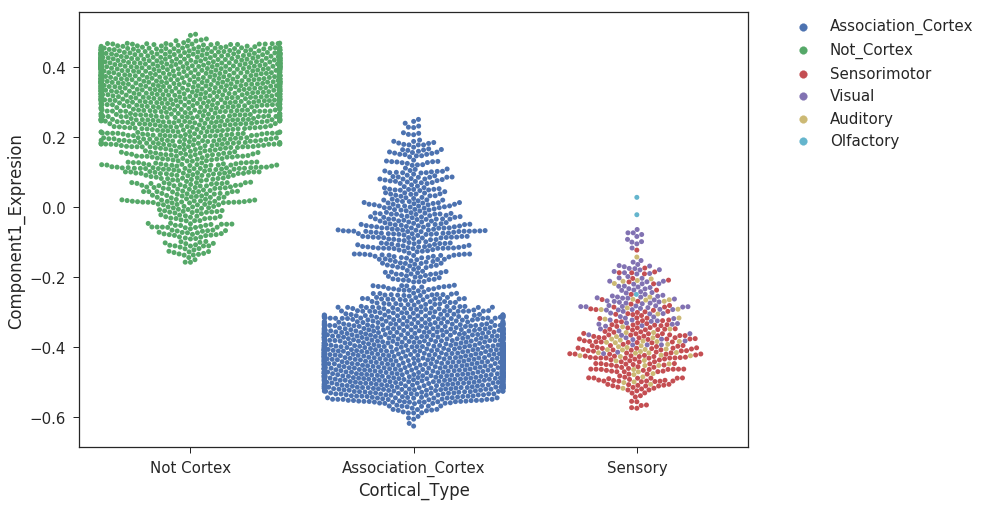

In [338]:
sns.set_context('notebook',font_scale=1.5)
plt.subplots(figsize=(12,8))
order = ['Not Cortex','Association_Cortex','Sensory']
sns.swarmplot(x='Cortical_Type', y='Component1_Expresion', data=gdf, hue='Sensory_Type', order=order)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ADDX/C1_Modals.pdf',
           bbox_inches='tight')

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning:

pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



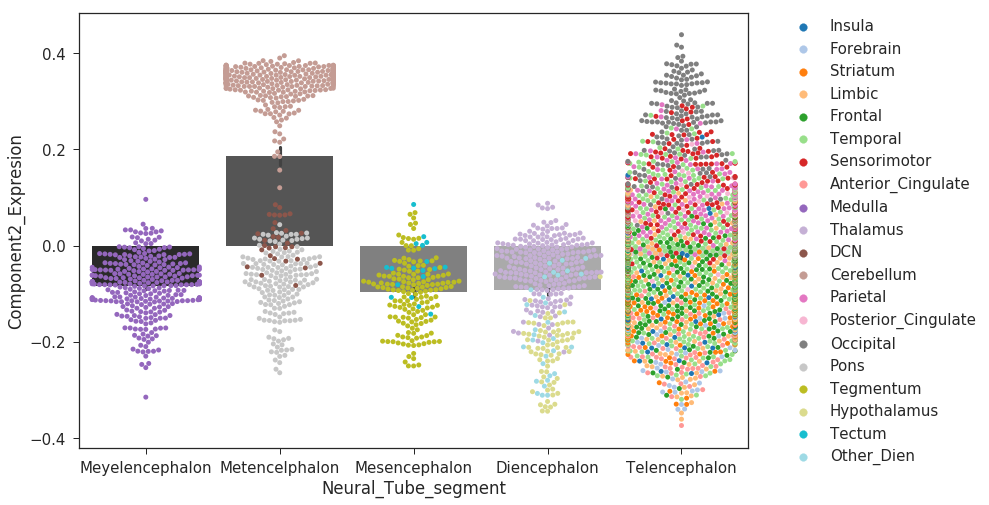

In [315]:
sns.set_context('notebook',font_scale=1.5)
plt.subplots(figsize=(12,8))
order = ['Meyelencephalon', 'Metencelphalon', 'Mesencephalon', 'Diencephalon', 'Telencephalon']
sns.barplot(x='Neural_Tube_segment', y='Component2_Expresion', data=gdf,palette='gray',
           order = order)
sns.swarmplot(x='Neural_Tube_segment', y='Component2_Expresion', data=gdf, hue='brain_divison',
              order = order, palette='tab20')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ADDX/C2_NT.pdf',
           bbox_inches='tight')

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning:

pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



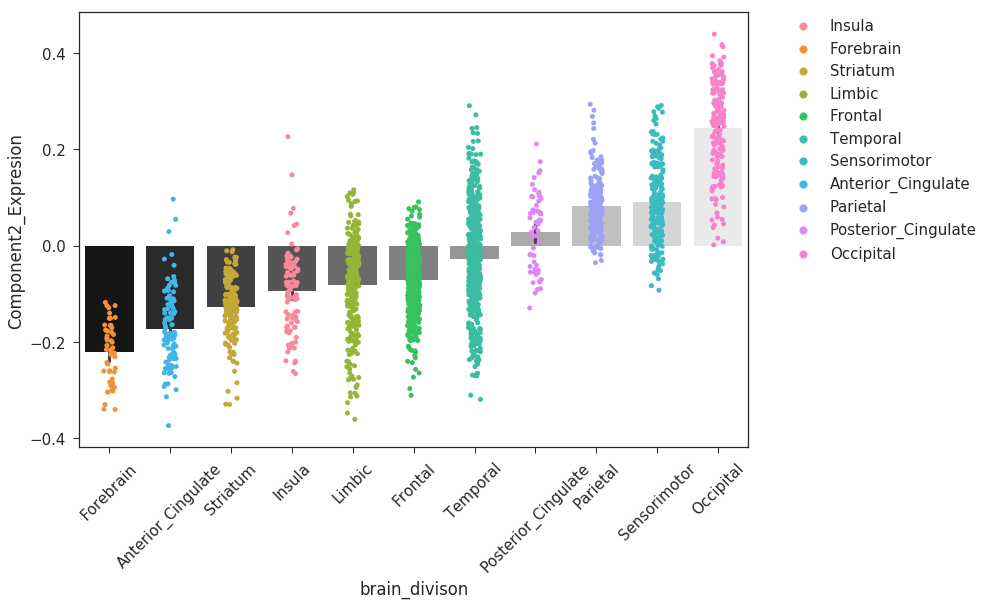

In [319]:
order = gdf[gdf.Neural_Tube_segment=='Telencephalon'
           ].pivot_table(values='Component2_Expresion',index = 'brain_divison'
                       ).sort_values('Component2_Expresion').index

plt.subplots(figsize=(12,8))
g=sns.barplot(x='brain_divison', y='Component2_Expresion', order = order,
            data=gdf[gdf.Neural_Tube_segment=='Telencephalon'], palette='gray',
           )
h=sns.stripplot(x='brain_divison', y='Component2_Expresion', order=order,jitter=True,
              hue='brain_divison',
            data=gdf[gdf.Neural_Tube_segment=='Telencephalon'],
           )
for item in h.get_xticklabels():
    item.set_rotation(45)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ADDX/C2_Tele.pdf',
           bbox_inches='tight')

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning:

pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead



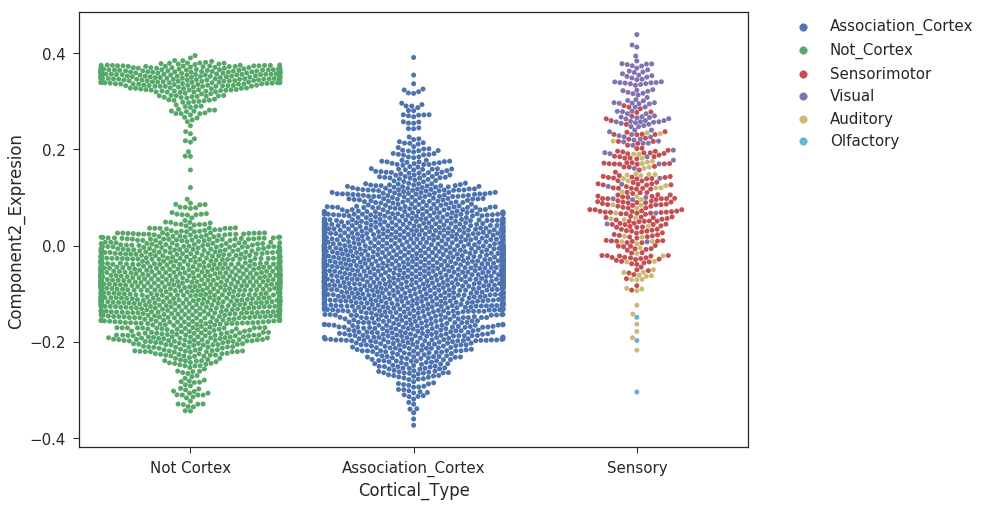

In [340]:
sns.set_context('notebook',font_scale=1.5)
plt.subplots(figsize=(12,8))
order = ['Not Cortex','Association_Cortex','Sensory']
sns.swarmplot(x='Cortical_Type', y='Component2_Expresion', data=gdf, hue='Sensory_Type', order=order)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ADDX/C2_Modals.pdf',
           bbox_inches='tight')

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning:

pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



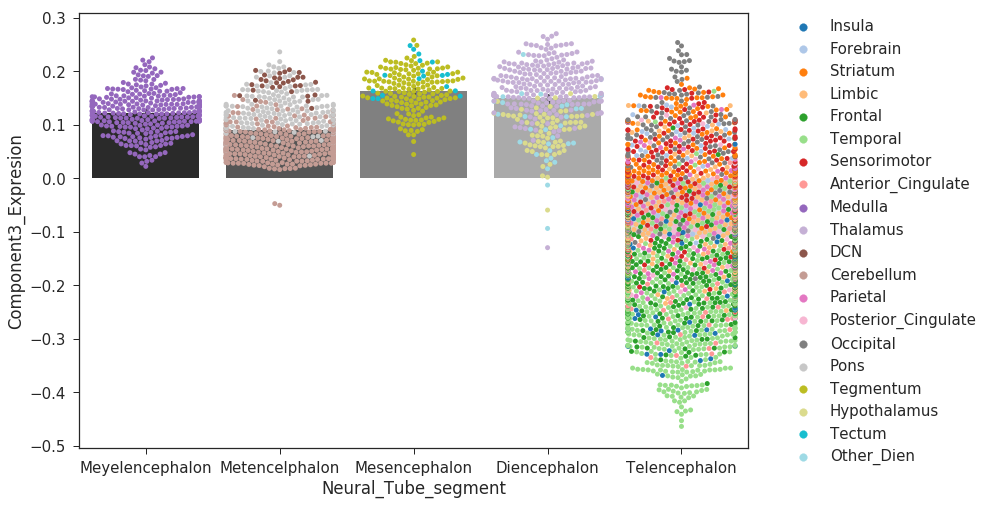

In [316]:
sns.set_context('notebook',font_scale=1.5)
plt.subplots(figsize=(12,8))
order = ['Meyelencephalon', 'Metencelphalon', 'Mesencephalon', 'Diencephalon', 'Telencephalon']
sns.barplot(x='Neural_Tube_segment', y='Component3_Expresion', data=gdf,palette='gray',
           order = order)
sns.swarmplot(x='Neural_Tube_segment', y='Component3_Expresion', data=gdf, hue='brain_divison',
              order = order, palette='tab20')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ADDX/C3_NT.pdf',
           bbox_inches='tight')

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning:

pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



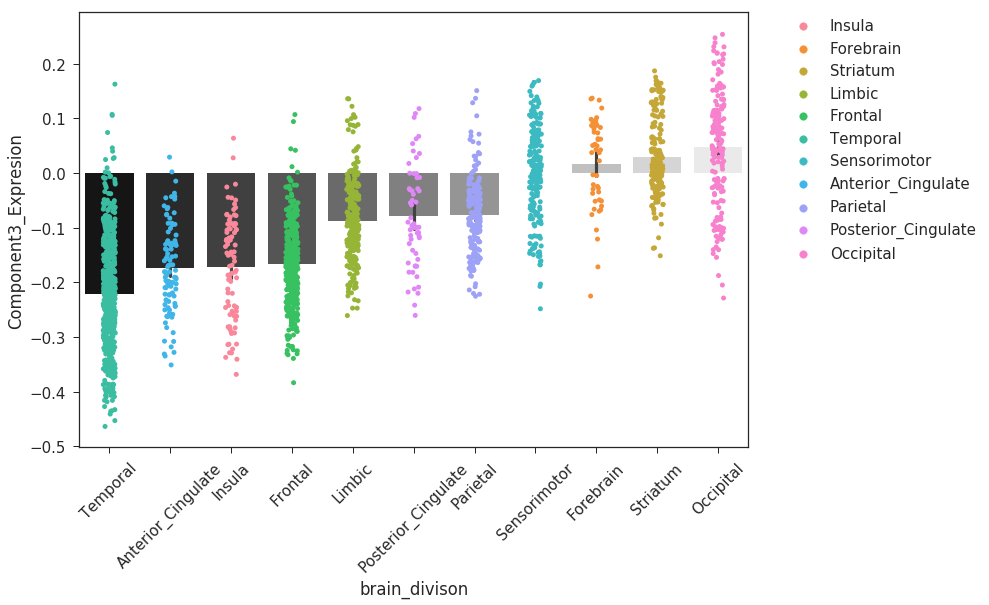

In [320]:
order = gdf[gdf.Neural_Tube_segment=='Telencephalon'
           ].pivot_table(values='Component3_Expresion',index = 'brain_divison'
                       ).sort_values('Component3_Expresion').index

plt.subplots(figsize=(12,8))
g=sns.barplot(x='brain_divison', y='Component3_Expresion', order = order,
            data=gdf[gdf.Neural_Tube_segment=='Telencephalon'], palette='gray',
           )
h=sns.stripplot(x='brain_divison', y='Component3_Expresion', order=order,jitter=True,
              hue='brain_divison',
            data=gdf[gdf.Neural_Tube_segment=='Telencephalon'],
           )
for item in h.get_xticklabels():
    item.set_rotation(45)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ADDX/C3_Tele.pdf',
           bbox_inches='tight')

In [260]:
gdf.columns[-10:]

Index(['new_structure_acronym', 'abs_mni_nlin_x', 'brain_divison',
       'Neural_Tube_segment', 'Sensory_Type', 'Cortical_Type',
       'Component1_Expresion', 'Component2_Expresion', 'Component3_Expresion',
       'bilateral_structure_name'],
      dtype='object')

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning:

pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead



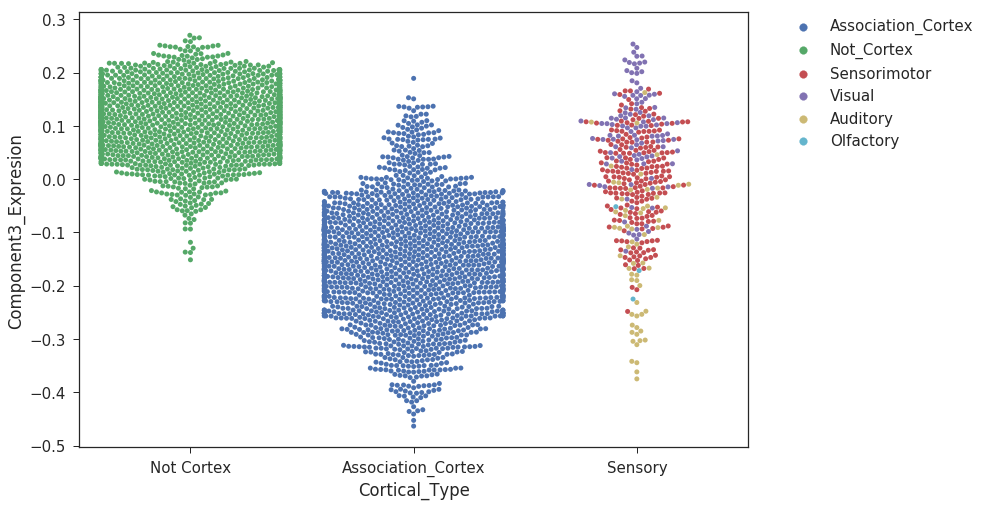

In [348]:
sns.set_context('notebook',font_scale=1.5)
plt.subplots(figsize=(12,8))
order = ['Not Cortex','Association_Cortex','Sensory']
sns.swarmplot(x='Cortical_Type', y='Component3_Expresion', data=gdf, hue='Sensory_Type',order=order)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ADDX/C3_Modals.pdf',
           bbox_inches='tight')

In [355]:
for col in gdf.columns[-4:-1]:
    

Index(['Component1_Expresion', 'Component2_Expresion', 'Component3_Expresion'], dtype='object')

//anaconda/envs/py3/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



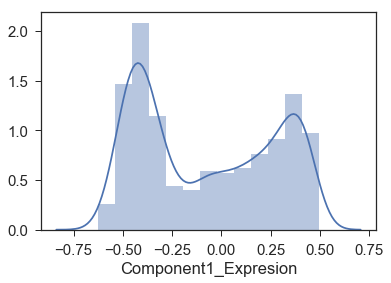

In [28]:
sns.distplot(gdf.Component1_Expresion)

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning:

object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.



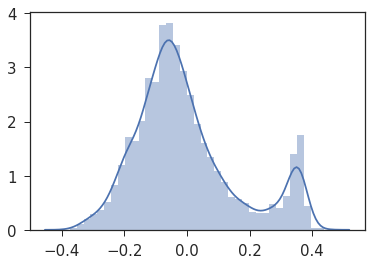

In [352]:
sns.distplot(c2_xp)

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning:

object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.



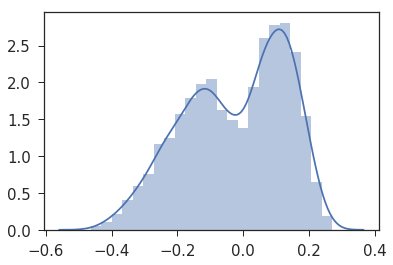

In [353]:
sns.distplot(c3_xp)

In [26]:
gdf = pandas.read_csv('/Users/jakevogel/Science/AHBA/MAIN_gcx_wholebrain_info_W_BRAIN_DIVISIONS.csv',
                     index_col=0)

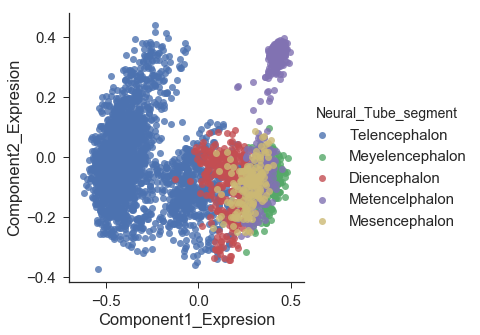

In [33]:
sns.lmplot(x='Component1_Expresion', y='Component2_Expresion', fit_reg=False,
            data=gdf, hue='Neural_Tube_segment')

In [39]:
dplot = gdf.pivot_table(values=['Component1_Expresion',
                        'Component2_Expresion',
                        'Component3_Expresion'],
                index=['brain_divison'])
dplot.loc[:,'Brain_Division'] = dplot.index.values
dplot.head()

Component1_Expresion  Component2_Expresion  \
brain_divison                                                    
Anterior_Cingulate             -0.420095             -0.172806   
Cerebellum                      0.422728              0.339967   
DCN                             0.327319              0.009842   
Forebrain                       0.058521             -0.221615   
Frontal                        -0.456023             -0.072089   

                    Component3_Expresion      Brain_Division  
brain_divison                                                 
Anterior_Cingulate             -0.173448  Anterior_Cingulate  
Cerebellum                      0.063479          Cerebellum  
DCN                             0.175887                 DCN  
Forebrain                       0.017051           Forebrain  
Frontal                        -0.166917             Frontal

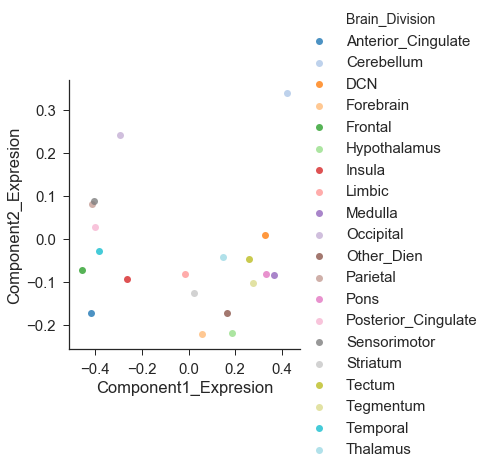

In [42]:
sns.lmplot(x='Component1_Expresion', y='Component2_Expresion', fit_reg=False, 
            data=dplot, hue='Brain_Division', palette='tab20')

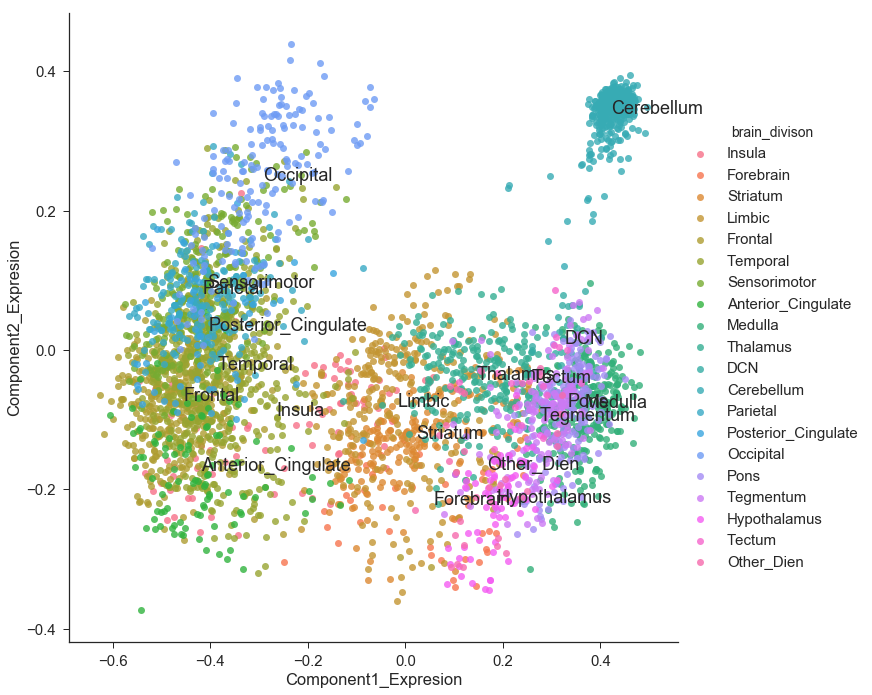

In [53]:
sns.lmplot(x='Component1_Expresion', y='Component2_Expresion', fit_reg=False, 
            data=gdf, hue='brain_divison',size=10,)
for bd in gdf.brain_divison.unique():
    if pandas.notnull(bd):
        nx = dplot.loc[bd,'Component1_Expresion']
        ny = dplot.loc[bd,'Component2_Expresion']
        plt.text(nx,ny,bd)
plt.savefig('/Users/jakevogel/Dropbox/McGill/Neur608/Final_Project/stuff/ADDX/C1C2_regions.pdf')

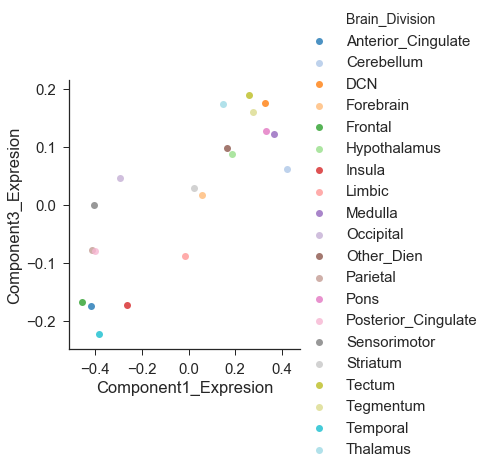

In [43]:
sns.lmplot(x='Component1_Expresion', y='Component3_Expresion', fit_reg=False, 
            data=dplot, hue='Brain_Division', palette='tab20')

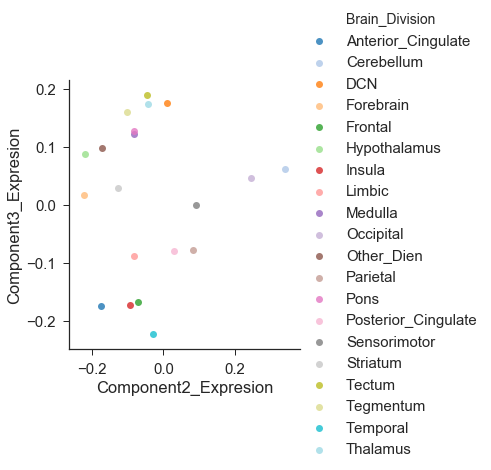

In [44]:
sns.lmplot(x='Component2_Expresion', y='Component3_Expresion', fit_reg=False, 
            data=dplot, hue='Brain_Division', palette='tab20')

In [51]:
code = dict(zip(gdf.brain_divison.unique().tolist(),
               range(len(gdf.brain_divison.unique().tolist()))))
labs = [code[x] if pandas.notnull(x) else 999 for x in gdf.brain_divison.values]
embedding = gdf[['Component1_Expresion',
                 'Component2_Expresion',
                 'Component3_Expresion']].values

lmap = {v: k for k, v in code.items()}
lmap.pop(19)
lmap.update({999: 'NaN'})
traces = list()
for lab in np.unique(labs):
    l_index = [x for x in range(len(labs)) if labs[x] == lab]
    l_embed = embedding[l_index]
#     color_str = str(int('0x' + color_dict[lab][1:3].upper(),16)) + ',' + \
#                    str(int('0x' + color_dict[lab][3:5].upper(),16)) + ',' + \
#                    str(int('0x' + color_dict[lab][5:7].upper(),16))
    #color_str = plt.cm.tab10.colors[lab]
    color_str = 'rgba %s'%str(tuple([x - 0.0000001 for x in plt.cm.tab20(lab) if x > 0]))
    temp_trace = plotly.graph_objs.Scatter3d(x=l_embed[:,0],
                                            y = l_embed[:,1],
                                            z = l_embed[:,2],
                                            name = lmap[lab],
                                            mode = 'markers',
                                            marker = dict(size=3,
                                                          color=color_str
                                                         )
                                            )
    traces.append(temp_trace)

layout = plotly.graph_objs.Layout(margin = dict(l=0,r=0,b=0,t=0))
         

fig = plotly.graph_objs.Figure(data=traces, layout=layout)
plotly.offline.plot(fig, 
                    filename='/Users/jakevogel/Science/AHBA/CBrain.html'
                   )
    

'file:///Users/jakevogel/Science/AHBA/CBrain.html'

In [ ]:
import abag

In [65]:
bs_sdf = pandas.read_csv('/Users/jakevogel/Science/AHBA/Brainspan/lmd_matrix_12840/columns_metadata.csv')
bs_probes = pandas.read_csv('/Users/jakevogel/Science/AHBA/Brainspan/lmd_matrix_12840/rows_metadata.csv')
bs_gxp = pandas.read_csv('/Users/jakevogel/Science/AHBA/Brainspan/lmd_matrix_12840/expression_matrix.csv',
                         header=None)
bs_gxp.head()

0         1         2         3         4         5         6    \
0  1058685  1.870266  2.500637  5.087565  1.375560  4.130802  4.113178   
1  1058684  6.297873  5.829589  4.539848  3.944338  4.044747  5.925640   
2  1058683  2.069434  2.828320  1.844547  1.429880  2.204994  1.598890   
3  1058682  2.002642  3.366205  4.754818  3.098781  4.431086  4.107063   
4  1058681  5.460101  6.524749  6.309441  6.213752  6.014018  6.083929   

        7         8         9      ...          318       319       320  \
0  5.524362  1.869377  4.435360    ...     1.730386  1.225932  1.323599   
1  8.025330  4.718171  5.240465    ...     4.403363  3.741472  3.804305   
2  1.882322  2.107117  2.319331    ...     1.699429  1.318732  1.361300   
3  2.043070  3.370859  5.421633    ...     5.698593  3.935162  2.617162   
4  5.731555  6.351332  7.388239    ...     7.673056  6.244501  6.025255   

        321       322       323       324       325       326       327  
0  2.192735  2.111756  0.844384  2.487709  0.964439  2.047743  2.082210  
1  4.889730  5.679992  3.350249  5.340184  3.912035  4.673747  4.016817  
2  2.247316  2.021892  2.997790  2.326233  1.020810  1.950179  1.557761  
3  3.745330  5.028064  4.820175  2.480152  4.254607  2.151463  2.368740  
4  6.244710  7.425317  6.963295  6.609604  5.972166  5.973547  5.634292  

[5 rows x 328 columns]

In [74]:
bs_gxp.shape

(58692, 328)

In [75]:
bs_sdf2 = pandas.read_csv('/Users/jakevogel/Science/AHBA/Brainspan/lmd_matrix_14751/columns_metadata.csv')
bs_probes2 = pandas.read_csv('/Users/jakevogel/Science/AHBA/Brainspan/lmd_matrix_14751/rows_metadata.csv')
bs_gxp2 = pandas.read_csv('/Users/jakevogel/Science/AHBA/Brainspan/lmd_matrix_14751/expression_matrix.csv',
                         header=None)

0         1         2         3         4         5         6    \
0  1058685  1.870266  2.500637  5.087565  1.375560  4.130802  4.113178   
1  1058684  6.297873  5.829589  4.539848  3.944338  4.044747  5.925640   
2  1058683  2.069434  2.828320  1.844547  1.429880  2.204994  1.598890   
3  1058682  2.002642  3.366205  4.754818  3.098781  4.431086  4.107063   
4  1058681  5.460101  6.524749  6.309441  6.213752  6.014018  6.083929   

        7         8         9      ...          318       319       320  \
0  5.524362  1.869377  4.435360    ...     1.730386  1.225932  1.323599   
1  8.025330  4.718171  5.240465    ...     4.403363  3.741472  3.804305   
2  1.882322  2.107117  2.319331    ...     1.699429  1.318732  1.361300   
3  2.043070  3.370859  5.421633    ...     5.698593  3.935162  2.617162   
4  5.731555  6.351332  7.388239    ...     7.673056  6.244501  6.025255   

        321       322       323       324       325       326       327  
0  2.192735  2.111756  0.844384  2.487709  0.964439  2.047743  2.082210  
1  4.889730  5.679992  3.350249  5.340184  3.912035  4.673747  4.016817  
2  2.247316  2.021892  2.997790  2.326233  1.020810  1.950179  1.557761  
3  3.745330  5.028064  4.820175  2.480152  4.254607  2.151463  2.368740  
4  6.244710  7.425317  6.963295  6.609604  5.972166  5.973547  5.634292  

[5 rows x 328 columns]

In [83]:
pandas.concat([bs_sdf,bs_sdf2]).structure_name.value_counts().sort_values(ascending=False)

outer CP in posterosuperior (dorsal) parietal cortex    2
inner CP in dorsomedial extrastriate cortex             2
pontobulbar body                                        2
VZ in rostral cingulate neocortex                       2
inner SZ in ventromedial extrastriate cortex            2
outer SZ in primary visual cortex                       2
rostral migratory stream                                2
MGE-Lateral region                                      2
IZ in frontal polar cortex                              2
outer CP in primary visual cortex                       2
SP in superolateral temporal cortex                     2
arcuate nucleus of hypothalamus                         2
VZ in orbital frontal cortex                            2
reticulotegmental nucleus                               2
SZ in subgenual cingulate cortex                        2
IZ in primary somatosensory cortex                      2
VZ in posterior parahippocampal cortex                  2
IZ in medial t

# Gene analysis

In [210]:
# Locate spreadsheets, which were generated using GOrilla

# Specifically, the specific genes produced in Set 1 and 2 above we're passed to GOrilla, and all genes
# available in the dataset were entered as background.
wdir  = '/Users/jakevogel/Dropbox/McGill/Neur608/Final_Project/stuff/ADDX/'
go_proc = os.path.join(wdir,'c3_neg_GOPROCESS.xls')
go_comp = os.path.join(wdir,'c3_neg_GOCOMPONENT.xls')
go_func = os.path.join(wdir,'c3_neg_GOFUNCTION.xls')

In [211]:
# Consolidate into a dataframe
gene_set = pandas.DataFrame(index=range(len(probes)),columns=['null'])
go_sheets = [go_proc,go_comp,go_func]
probedf = probes

ind = probedf.gene_symbol.unique()
cols = []
gos = []
for sht in go_sheets:
    try:
        jnk = pandas.ExcelFile(sht)
        go = pandas.ExcelFile(sht).parse(jnk.sheet_names[0])
    except:
        go = pandas.read_table(sht)
    gos.append(go)
    cols += go.Description.tolist()

go_gsea = pandas.DataFrame(np.zeros((len(ind),len(cols))), index=ind, columns = cols) 

for go in gos:
    for i,row in go.iterrows():
        jnk = row['Genes']
        jnk = jnk.replace('[','')
        jnk = jnk.replace(']','')
        genes = [x for x in jnk.split(' ') if x.isupper()]
        misses = [genes.pop(genes.index(x)) for x in genes if x not in go_gsea.index]
        misses = [genes.pop(genes.index(x)) for x in genes if x not in go_gsea.index]
        go_gsea.loc[genes,row['Description']] = 1
        for gene in misses:
            go_gsea.loc[gene,row['Description']] = 1

go_gsea.fillna(0,inplace=True)

# Drop genes with 0 hits
go_gsea.drop([x for x in go_gsea.index if all(go_gsea.loc[x].values == 0)],inplace=True)

In [212]:
go_gsea.shape

(1667, 624)

In [162]:
# # Quick preview of what the clusters might look like

# plt.close()
# sns.clustermap(go_gsea, metric='jaccard', col_cluster=False)
# plt.show()

In [213]:

from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import calinski_harabaz_score
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering

# Cluster using 2-30-cluster solutions and compare based on silhouette scores and CH index 

# Create results dataframe
ks = range(2,31)
go_solutions2 = pandas.DataFrame(index = ks, columns = ['silhouette', 'CH_index',
                                                             'mean_size','min_size','max_size'])
X = go_gsea.values.T
for k in ks:
    # Perform cluster analysis
    connectivity = kneighbors_graph(X, n_neighbors=10, mode='distance', 
                                    metric = 'jaccard', include_self=False)
    clusterer = AgglomerativeClustering(n_clusters=k, connectivity=connectivity)
    cluster_labels = clusterer.fit_predict(X)
    # silhouette
    go_solutions2.loc[k,'silhouette'] = silhouette_score(X, cluster_labels)
    # CH Index
    go_solutions2.loc[k,'CH_index'] = calinski_harabaz_score(X, cluster_labels)
    # Get information on cluster size
    mtx2 = pandas.DataFrame(go_gsea.T.values, copy=True)
    mtx2.loc[:,'label'] = cluster_labels
    sizes = []
    for i in np.unique(mtx2.label):
        clus_data = mtx2[mtx2.label==i][mtx2.columns[:-1]]
        sizes.append(len(clus_data))
    # SIZES
    go_solutions2.loc[k,'mean_size'] = np.mean(sizes)
    go_solutions2.loc[k,'min_size'] = np.min(sizes)
    go_solutions2.loc[k,'max_size'] = np.max(sizes)
    print('finished',k)
go_solutions2.loc[:,'k'] = go_solutions2.index

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cluster/hierarchical.py:193: UserWarning:

the number of connected components of the connectivity matrix is 6 > 1. Completing it to avoid stopping the tree early.



finished 2
finished 3
finished 4
finished 5
finished 6
finished 7
finished 8
finished 9
finished 10
finished 11
finished 12
finished 13
finished 14
finished 15
finished 16
finished 17
finished 18
finished 19
finished 20
finished 21
finished 22
finished 23
finished 24
finished 25
finished 26
finished 27
finished 28
finished 29
finished 30


//anaconda/envs/py3/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



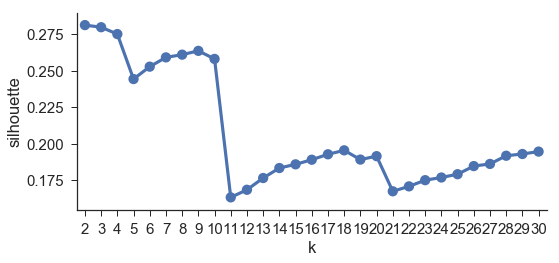

In [214]:
plt.close()
sns.factorplot(x='k',y='silhouette',data=go_solutions2,aspect=2)
plt.show()

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cluster/hierarchical.py:193: UserWarning:

the number of connected components of the connectivity matrix is 6 > 1. Completing it to avoid stopping the tree early.



cluster 0
n =  102


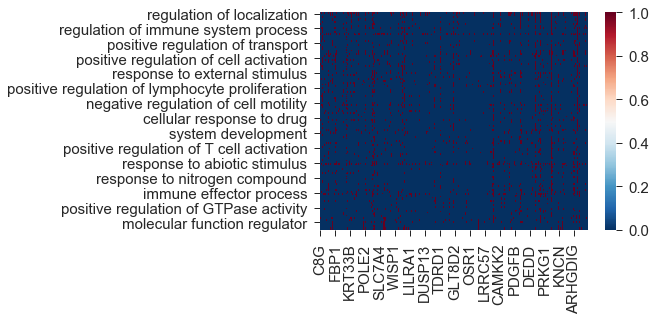

RNASET2      1.0
PAPSS2       1.0
CCNYL1       1.0
CHAF1B       1.0
HIST1H2BK    1.0
HIST1H2BC    1.0
NUDT2        1.0
HSPB3        1.0
DENND2C      1.0
CPNE8        1.0
RNASEH2A     1.0
SP140        1.0
OLFML2B      1.0
NUDCD1       1.0
TEP1         1.0
MCM10        1.0
NIT2         1.0
KIF12        1.0
DCLRE1B      1.0
DENND1C      1.0
dtype: float64
[('RNASET2', 1.0, 'ribonuclease T2'), ('PAPSS2', 1.0, "3'-phosphoadenosine 5'-phosphosulfate synthase 2"), ('CCNYL1', 1.0, 'cyclin Y-like 1'), ('CHAF1B', 1.0, 'chromatin assembly factor 1, subunit B (p60)'), ('HIST1H2BK', 1.0, 'histone cluster 1, H2bk'), ('HIST1H2BC', 1.0, array(['histone cluster 1, H2bc'], dtype=object)), ('NUDT2', 1.0, 'nudix (nucleoside diphosphate linked moiety X)-type motif 2'), ('HSPB3', 1.0, 'heat shock 27kDa protein 3'), ('DENND2C', 1.0, 'DENN/MADD domain containing 2C'), ('CPNE8', 1.0, 'copine VIII'), ('RNASEH2A', 1.0, 'ribonuclease H2, subunit A'), ('SP140', 1.0, 'SP140 nuclear body protein'), ('OLFML2B', 1.0, 

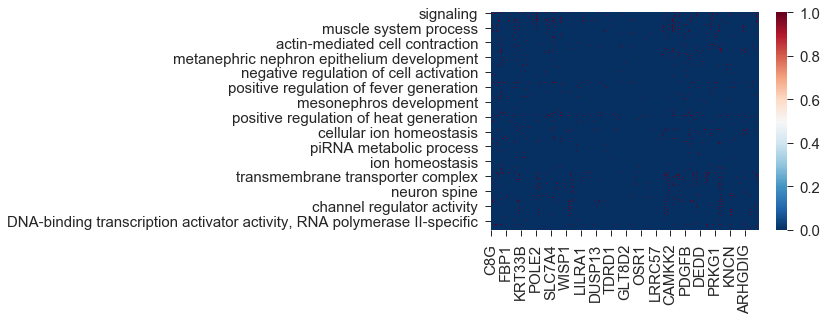

TMSB15A     1.0
FSTL5       1.0
PCDHGA9     1.0
PNMT        1.0
MTMR12      1.0
MYO5C       1.0
PCDHGA12    1.0
LAYN        1.0
CAPSL       1.0
MYO1F       1.0
PCDH18      1.0
TBC1D28     1.0
NT5DC3      1.0
CAPN5       1.0
DUSP13      1.0
AGBL1       1.0
SERPINB8    1.0
FAM26F      1.0
PDZRN3      1.0
MPP4        1.0
dtype: float64
[('TMSB15A', 1.0, 'thymosin beta 15a'), ('FSTL5', 1.0, 'follistatin-like 5'), ('PCDHGA9', 1.0, 'protocadherin gamma subfamily A, 9'), ('PNMT', 1.0, 'phenylethanolamine N-methyltransferase'), ('MTMR12', 1.0, 'myotubularin related protein 12'), ('MYO5C', 1.0, 'myosin VC'), ('PCDHGA12', 1.0, 'protocadherin gamma subfamily A, 12'), ('LAYN', 1.0, 'layilin'), ('CAPSL', 1.0, 'calcyphosine-like'), ('MYO1F', 1.0, 'myosin IF'), ('PCDH18', 1.0, 'protocadherin 18'), ('TBC1D28', 1.0, 'TBC1 domain family, member 28'), ('NT5DC3', 1.0, "5'-nucleotidase domain containing 3"), ('CAPN5', 1.0, 'calpain 5'), ('DUSP13', 1.0, 'dual specificity phosphatase 13'), ('AGBL1', 1.0, 'AT

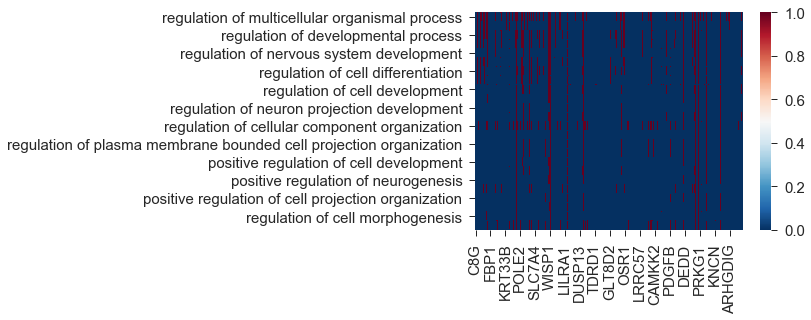

PATL2      1.000000
SPTY2D1    1.000000
FERD3L     0.875000
CUL7       0.857143
SYT17      0.750000
ISLR2      0.727273
MKL2       0.714286
CPNE5      0.685714
FKBPL      0.666667
LINGO2     0.615385
TTL        0.608696
CDH4       0.600000
PTPN9      0.578947
AVIL       0.575758
TUBB2B     0.571429
SH3GL3     0.560000
LINGO1     0.560000
BAI3       0.545455
NR2F1      0.521739
XK         0.521739
dtype: float64
[('PATL2', 1.0, 'protein associated with topoisomerase II homolog 2 (yeast)'), ('SPTY2D1', 1.0, 'SPT2, Suppressor of Ty, domain containing 1 (S. cerevisiae)'), ('FERD3L', 0.875, 'Fer3-like (Drosophila)'), ('CUL7', 0.8571428571428571, 'cullin 7'), ('SYT17', 0.75, 'synaptotagmin XVII'), ('ISLR2', 0.7272727272727273, 'immunoglobulin superfamily containing leucine-rich repeat 2'), ('MKL2', 0.7142857142857143, array(['MKL/myocardin-like 2'], dtype=object)), ('CPNE5', 0.6857142857142857, 'copine V'), ('FKBPL', 0.6666666666666666, 'FK506 binding protein like'), ('LINGO2', 0.61538461538

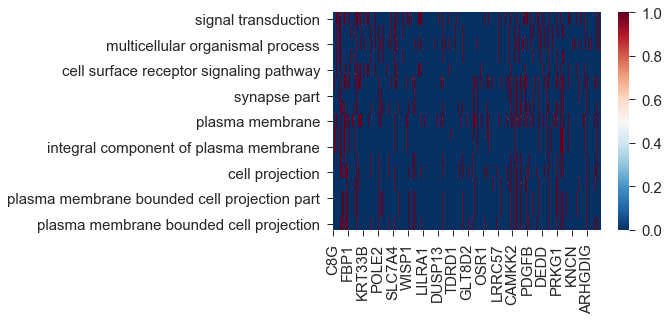

CCDC19       1.000000
LOC643037    1.000000
KRTAP6-3     1.000000
KRTAP20-1    1.000000
RSPH3        1.000000
AK7          1.000000
DPF3         1.000000
AKAP14       1.000000
KRT86        1.000000
CCDC41       1.000000
CCDC68       1.000000
FAM126A      0.833333
RSPH9        0.800000
CYS1         0.750000
KIF21B       0.750000
DMWD         0.750000
ADAM29       0.750000
SYT13        0.750000
GPRIN1       0.750000
SYNPR        0.714286
dtype: float64
[('CCDC19', 1.0, 'coiled-coil domain containing 19'), ('LOC643037', 1.0, 'uncharacterized LOC643037'), ('KRTAP6-3', 1.0, 'keratin associated protein 6-3'), ('KRTAP20-1', 1.0, 'keratin associated protein 20-1'), ('RSPH3', 1.0, 'radial spoke 3 homolog (Chlamydomonas)'), ('AK7', 1.0, 'adenylate kinase 7'), ('DPF3', 1.0, 'D4, zinc and double PHD fingers, family 3'), ('AKAP14', 1.0, 'A kinase (PRKA) anchor protein 14'), ('KRT86', 1.0, 'keratin 86'), ('CCDC41', 1.0, 'coiled-coil domain containing 41'), ('CCDC68', 1.0, 'coiled-coil domain contain

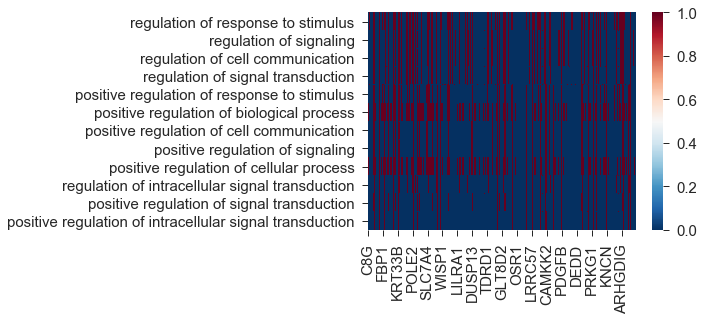

GLTSCR1          1.000000
MEF2BNB-MEF2B    1.000000
PBX4             1.000000
MLN              1.000000
FGF6             1.000000
NSMCE4A          1.000000
NUB1             1.000000
MED27            1.000000
TFAP2D           1.000000
DKK2             0.909091
TMED4            0.857143
USP18            0.800000
RUNDC3A          0.800000
SLA              0.769231
SH3BGR           0.769231
TRAF5            0.700000
IGFBP4           0.666667
LARP6            0.666667
SOX12            0.666667
FAM175A          0.666667
dtype: float64
[('GLTSCR1', 1.0, 'glioma tumor suppressor candidate region gene 1'), ('MEF2BNB-MEF2B', 1.0, 'MEF2BNB-MEF2B readthrough'), ('PBX4', 1.0, 'pre-B-cell leukemia homeobox 4'), ('MLN', 1.0, 'motilin'), ('FGF6', 1.0, 'fibroblast growth factor 6'), ('NSMCE4A', 1.0, 'non-SMC element 4 homolog A (S. cerevisiae)'), ('NUB1', 1.0, 'negative regulator of ubiquitin-like proteins 1'), ('MED27', 1.0, 'mediator complex subunit 27'), ('TFAP2D', 1.0, 'transcription factor AP-2 de

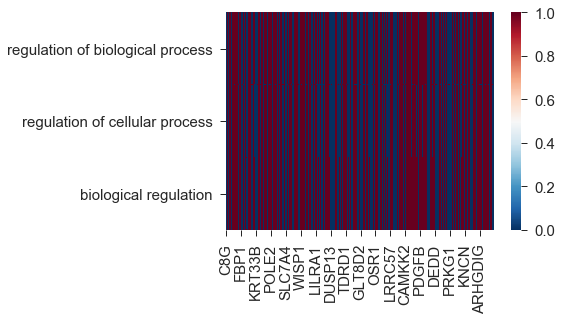

ZNF697      1.0
ZNF184      1.0
TCEA3       1.0
CCNA1       1.0
SIN3B       1.0
TP53AIP1    1.0
WDHD1       1.0
ZFP28       1.0
ZBTB8B      1.0
INCENP      1.0
ZNF572      1.0
ZNF727      1.0
SRRD        1.0
ZFP64       1.0
ZNF215      1.0
PM20D2      1.0
SNAPC5      1.0
L3MBTL4     1.0
ZNF765      1.0
DEDD        1.0
dtype: float64
[('ZNF697', 1.0, 'zinc finger protein 697'), ('ZNF184', 1.0, 'zinc finger protein 184'), ('TCEA3', 1.0, 'transcription elongation factor A (SII), 3'), ('CCNA1', 1.0, 'cyclin A1'), ('SIN3B', 1.0, 'SIN3 transcription regulator homolog B (yeast)'), ('TP53AIP1', 1.0, 'tumor protein p53 regulated apoptosis inducing protein 1'), ('WDHD1', 1.0, 'WD repeat and HMG-box DNA binding protein 1'), ('ZFP28', 1.0, 'zinc finger protein 28 homolog (mouse)'), ('ZBTB8B', 1.0, 'zinc finger and BTB domain containing 8B'), ('INCENP', 1.0, 'inner centromere protein antigens 135/155kDa'), ('ZNF572', 1.0, 'zinc finger protein 572'), ('ZNF727', 1.0, 'zinc finger protein 727'), ('SRR

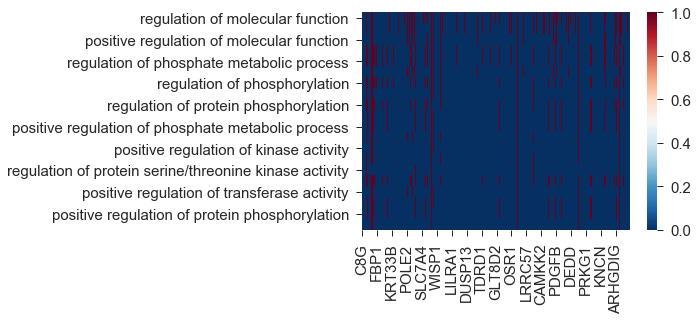

LATS2      0.714286
CLSPN      0.678571
PSRC1      0.666667
CCND2      0.666667
CENPE      0.655172
TOM1L1     0.633333
TPX2       0.558824
CDC25C     0.555556
CDC6       0.500000
CABIN1     0.500000
NHLRC1     0.500000
AGAP2      0.482759
FNIP2      0.478261
FCGR1A     0.463415
RPS6KA4    0.458333
HERC5      0.454545
C1QTNF2    0.450000
MRE11A     0.447368
LRCOL1     0.444444
PKIB       0.428571
dtype: float64
[('LATS2', 0.7142857142857143, 'LATS, large tumor suppressor, homolog 2 (Drosophila)'), ('CLSPN', 0.6785714285714286, 'claspin'), ('PSRC1', 0.6666666666666666, 'proline/serine-rich coiled-coil 1'), ('CCND2', 0.6666666666666666, 'cyclin D2'), ('CENPE', 0.6551724137931034, 'centromere protein E, 312kDa'), ('TOM1L1', 0.6333333333333333, array(['target of myb1 (chicken)-like 1'], dtype=object)), ('TPX2', 0.5588235294117647, 'TPX2, microtubule-associated, homolog (Xenopus laevis)'), ('CDC25C', 0.5555555555555556, 'cell division cycle 25 homolog C (S. pombe)'), ('CDC6', 0.5, 'cell div

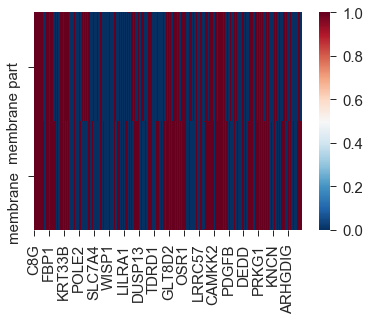

DUSP2       1.0
HCCS        1.0
LINGO3      1.0
SLC29A3     1.0
TMEM132A    1.0
SLC10A3     1.0
TMEM242     1.0
THSD1       1.0
TMEM159     1.0
ASPHD2      1.0
MS4A7       1.0
WBSCR17     1.0
SUSD1       1.0
NDST4       1.0
STAMBPL1    1.0
BEGAIN      1.0
TMEM180     1.0
TMEM200A    1.0
TRAF3IP3    1.0
ZDHHC14     1.0
dtype: float64
[('DUSP2', 1.0, 'dual specificity phosphatase 2'), ('HCCS', 1.0, 'holocytochrome c synthase'), ('LINGO3', 1.0, 'leucine rich repeat and Ig domain containing 3'), ('SLC29A3', 1.0, 'solute carrier family 29 (nucleoside transporters), member 3'), ('TMEM132A', 1.0, 'transmembrane protein 132A'), ('SLC10A3', 1.0, 'solute carrier family 10 (sodium/bile acid cotransporter family), member 3'), ('TMEM242', 1.0, 'transmembrane protein 242'), ('THSD1', 1.0, 'thrombospondin, type I, domain containing 1'), ('TMEM159', 1.0, 'transmembrane protein 159'), ('ASPHD2', 1.0, 'aspartate beta-hydroxylase domain containing 2'), ('MS4A7', 1.0, 'membrane-spanning 4-domains, subfami

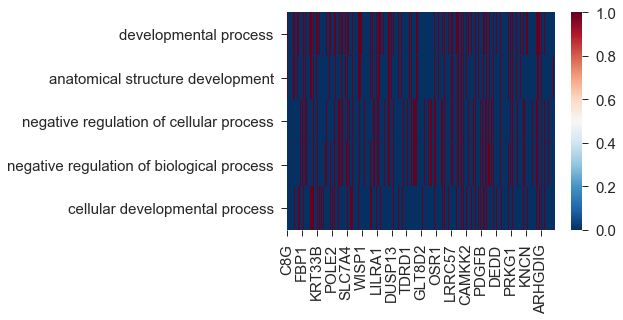

FAM172A    1.000000
CCIN       1.000000
MEI1       1.000000
CA10       1.000000
SPEF2      1.000000
FBXO40     1.000000
MEIG1      1.000000
WDR62      1.000000
SOX2-OT    1.000000
PTER       1.000000
CHRDL2     1.000000
NNAT       1.000000
ZNF521     1.000000
DMC1       1.000000
TUBB8      1.000000
SPINK2     1.000000
VIT        1.000000
TDRD5      0.750000
THEG       0.750000
MLF1IP     0.666667
dtype: float64
[('FAM172A', 1.0, 'family with sequence similarity 172, member A'), ('CCIN', 1.0, 'calicin'), ('MEI1', 1.0, 'meiosis inhibitor 1'), ('CA10', 1.0, 'carbonic anhydrase X'), ('SPEF2', 1.0, 'sperm flagellar 2'), ('FBXO40', 1.0, 'F-box protein 40'), ('MEIG1', 1.0, 'meiosis expressed gene 1 homolog (mouse)'), ('WDR62', 1.0, 'WD repeat domain 62'), ('SOX2-OT', 1.0, 'SOX2 overlapping transcript (non-protein coding)'), ('PTER', 1.0, 'phosphotriesterase related'), ('CHRDL2', 1.0, 'chordin-like 2'), ('NNAT', 1.0, 'neuronatin'), ('ZNF521', 1.0, 'zinc finger protein 521'), ('DMC1', 1.0, 'DMC

In [215]:
# Run clustering based on using a solution of K=8

k = 9 

# Perform clustering and extract labels
X = go_gsea.values.T
connectivity = kneighbors_graph(X, n_neighbors=10, mode='distance', 
                                    metric = 'jaccard', include_self=False)
clusterer = AgglomerativeClustering(n_clusters=k, connectivity=connectivity)
cluster_labels = clusterer.fit_predict(X)
mtx2 = pandas.DataFrame(go_gsea.T, copy=True)
mtx2.loc[:,'label'] = cluster_labels

# For each cluster
for i in np.unique(mtx2.label):
    print('cluster',i)
    # Extract data from the cluster
    clus_data = mtx2[mtx2.label==i][mtx2.columns[:-1]]
    print('n = ',len(clus_data))
    # Plot it
    plt.close()
    sns.heatmap(pandas.DataFrame(clus_data),
               cmap = 'RdBu_r')
    plt.show()
    
    # Identify the most frequently enriched terms in the cluster
    # and the percentage of genes in the cluster that show enrichment
    # for each term
    top_hits = (clus_data.sum()/go_gsea.T.sum()).sort_values(ascending=False).head(20)
    print(top_hits)
    names = [probes[probes.gene_symbol==x]['gene_name'].values[0]\
             if len(probes[probes.gene_symbol==x]) > 1\
             else probes[probes.gene_symbol==x]['gene_name'].values for x in top_hits.index]
    print(list(zip(top_hits.index,top_hits.values,names)))
    # Print the most enriched genes
    print(clus_data.index.tolist())
    

In [217]:
gos[0].loc[:,'Enrichment'] = pandas.to_numeric([x.replace(',','') if ',' in x\
                                                                 else x\
                                                for x in gos[0].loc[:,'Enrichment']])

In [218]:
gos[0].sort_values('Enrichment',ascending=False).head(100)

GO Term                                        Description  \
346  GO:0061360                          optic chiasma development   
345  GO:2000597       positive regulation of optic nerve formation   
344  GO:2000595                regulation of optic nerve formation   
487  GO:0070495  negative regulation of thrombin-activated rece...   
486  GO:0070494  regulation of thrombin-activated receptor sign...   
403  GO:1903815  negative regulation of collecting lymphatic ve...   
402  GO:1903814  regulation of collecting lymphatic vessel cons...   
455  GO:0021633                optic nerve structural organization   
454  GO:0035566                     regulation of metanephros size   
453  GO:0002072  optic cup morphogenesis involved in camera-typ...   
433  GO:0021528  commissural neuron differentiation in spinal cord   
296  GO:0031622            positive regulation of fever generation   
257  GO:0002225  positive regulation of antimicrobial peptide p...   
258  GO:0002760  positive regulation of antimicrobial humoral r...   
259  GO:0002803  positive regulation of antibacterial peptide p...   
107  GO:0021615               glossopharyngeal nerve morphogenesis   
361  GO:0031652             positive regulation of heat generation   
277  GO:0072305  negative regulation of mesenchymal cell apopto...   
278  GO:0072004                         kidney field specification   
276  GO:0072304  regulation of mesenchymal cell apoptotic proce...   
274  GO:2000592  regulation of metanephric DCT cell differentia...   
273  GO:1900214  regulation of apoptotic process involved in me...   
272  GO:1900217  regulation of apoptotic process involved in me...   
271  GO:1900218  negative regulation of apoptotic process invol...   
275  GO:2000594  positive regulation of metanephric DCT cell di...   
270  GO:1900215  negative regulation of apoptotic process invol...   
268  GO:0039017  pattern specification involved in pronephros d...   
269  GO:0039003                     pronephric field specification   
368  GO:0021554                            optic nerve development   
325  GO:0002784     regulation of antimicrobial peptide production   
..          ...                                                ...   
205  GO:0072170                     metanephric tubule development   
207  GO:0072243         metanephric nephron epithelium development   
231  GO:0035589  G protein-coupled purinergic nucleotide recept...   
233  GO:0072207                 metanephric epithelium development   
337  GO:0046643        regulation of gamma-delta T cell activation   
435  GO:0150062                complement-mediated synapse pruning   
434  GO:0150064                 vertebrate eye-specific patterning   
246  GO:0015671                                   oxygen transport   
427  GO:0034587                            piRNA metabolic process   
470  GO:0061005  cell differentiation involved in kidney develo...   
170  GO:0048704            embryonic skeletal system morphogenesis   
473  GO:0072009                     nephron epithelium development   
117  GO:0007210               serotonin receptor signaling pathway   
377  GO:0048863                          stem cell differentiation   
340  GO:0015669                                      gas transport   
279  GO:0098664  G protein-coupled serotonin receptor signaling...   
415  GO:0007586                                          digestion   
365  GO:0072080                         nephron tubule development   
250  GO:0035588  G protein-coupled purinergic receptor signalin...   
320  GO:1902565       positive regulation of neutrophil activation   
319  GO:0043315    positive regulation of neutrophil degranulation   
135  GO:0098883                                    synapse pruning   
184  GO:0048562                      embryonic organ morphogenesis   
431  GO:0033239  negative regulation of cellular amine metaboli...   
406  GO:0061326                           renal tubule development   
247  GO:0048705   

In [221]:
gos[2].sort_values('FDR q-value',ascending=True).head(100)

GO Term                                        Description  \
0   GO:0098772                       molecular function regulator   
1   GO:0005509                                calcium ion binding   
2   GO:0030594                 neurotransmitter receptor activity   
3   GO:0005246                 calcium channel regulator activity   
4   GO:0016247                         channel regulator activity   
7   GO:0022838                substrate-specific channel activity   
8   GO:0099528  G protein-coupled neurotransmitter receptor ac...   
6   GO:0022803         passive transmembrane transporter activity   
5   GO:0015267                                   channel activity   
9   GO:0005216                               ion channel activity   
10  GO:0005261                            cation channel activity   
11  GO:0099106                     ion channel regulator activity   
12  GO:0004252                 serine-type endopeptidase activity   
13  GO:0022839                         ion gated channel activity   
15  GO:0022843              voltage-gated cation channel activity   
14  GO:0022836                             gated channel activity   
16  GO:0008236                     serine-type peptidase activity   
17  GO:0017171                          serine hydrolase activity   
18  GO:0008227          G protein-coupled amine receptor activity   
21  GO:0005244                 voltage-gated ion channel activity   
19  GO:0003779                                      actin binding   
22  GO:0004175                             endopeptidase activity   
20  GO:0022832                     voltage-gated channel activity   
23  GO:0038023                        signaling receptor activity   
24  GO:0005230    extracellular ligand-gated ion channel activity   
25  GO:0004888          transmembrane signaling receptor activity   
26  GO:0005004                GPI-linked ephrin receptor activity   
28  GO:0004993      G protein-coupled serotonin receptor activity   
29  GO:0051015                             actin filament binding   
27  GO:0099589                        serotonin receptor activity   
30  GO:0004957                  prostaglandin E receptor activity   
32  GO:0060089                      molecular transducer activity   
31  GO:0048018                           receptor ligand activity   
33  GO:0005262                           calcium channel activity   
34  GO:0099095                ligand-gated anion channel activity   
35  GO:0030545                        receptor regulator activity   
36  GO:0001228  DNA-binding transcription activator activity, ...   
39  GO:0001621                              ADP receptor activity   
40  GO:0005102                         signaling receptor binding   
37  GO:0015085     calcium ion transmembrane transporter activity   
38  GO:0031432                                      titin binding   
41  GO:0004603    phenylethanolamine N-methyltransferase activity   
42  GO:0004983                   neuropeptide Y receptor activity   
43  GO:0016907  G protein-coupled acetylcholine receptor activity   
45  GO:0046873       metal ion transmembrane transporter activity   
44  GO:0005245             voltage-gated calcium channel activity   
46  GO:0008092                       cytoskeletal protein binding   
48  GO:0015276                  ligand-gated ion channel activity   
50  GO:0022835                 transmitter-gated channel activity   
53  GO:0035586                       purinergic receptor activity   
51  GO:0034632         retinol transmembrane transporter activity   
47  GO:0022834                      ligand-gated channel activity   
49  GO:0022824             transmitter-gated ion channel activity   
52  GO:0001601                       peptide YY receptor activity   
54  GO:0070011  peptidase activity, acting on L-amino acid pep...   
55  GO:0044325                                ion channel binding   

         P-value   FDR q-value Enrichment      N     B     n    b  \
0   